**Số liệu thống kê thực trạng của deepfakes technology đến 2024**

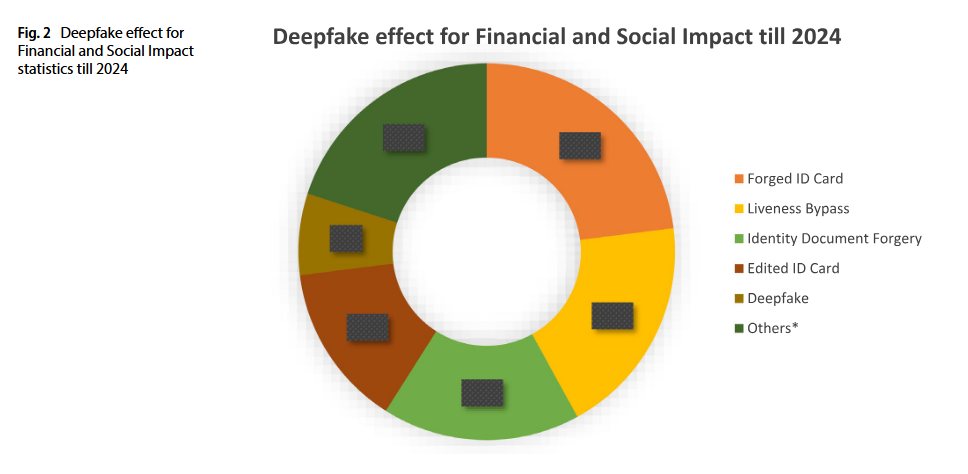
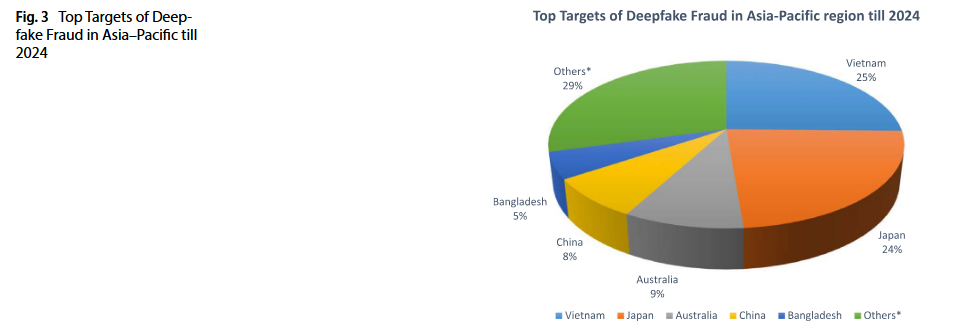
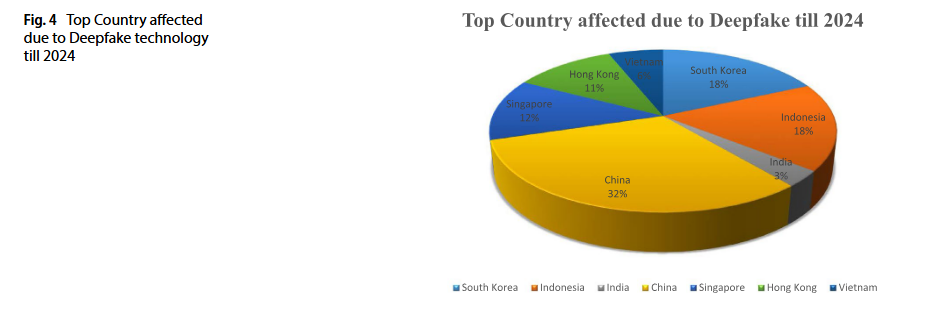

Source paper: Advancements_in_detecting_Deepfakes_AI_algorithms\*.pdf


# Task

Nghiên cứu phát triển mô hình phát hiện hình ảnh giả mạo (deepfake image) bằng học sâu

- Sử dụng tập dữ liệu "https://www.kaggle.com/datasets/hungle3401/faceforensics"
- Data Augementation : Traditional 
- Mô hình EfficientNetB0


### Check system configuration


In [1]:
import tensorflow as tf
import sys
import platform
import psutil

print("================================================")
print("      Check system configuration of PYTHON/GPU")
print("================================================")

# --- 1. Check version TensorFlow ---
print(f"✅ Version TensorFlow: {tf.__version__}")
if tf.config.list_physical_devices("GPU"):
    print("✅ TensorFlow are regconized GPU.")
else:
    print("⚠️ Warning: TensorFlow does NOT recognize GPU. Training will be very slow.")

# --- 2. Check available GPU devices ---
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print(f"\n✨ TOTAL GPU DEVICES: {len(gpus)}")
    try:
        # Limit GPU memory usage to avoid crashes
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"   - GPU Name: {gpu.name}")
    except RuntimeError as e:
        print(f"❌ GPU memory configuration error: {e}")
else:
    print("   - No GPU found, running on CPU.")


# --- 3. Check System Configuration (CPU/RAM) ---
print("\n🖥️ SYSTEM INFORMATION:")
print(f"   - Operating System: {platform.system()} {platform.release()}")
print(f"   - Python Version: {sys.version}")
print(f"   - Number of CPU Cores: {psutil.cpu_count(logical=False)} (Physical)")
# --- 4. Check Memory (RAM) ---
mem = psutil.virtual_memory()
total_ram_gb = mem.total / (1024**3)
available_ram_gb = mem.available / (1024**3)

print(f"   - Total RAM: {total_ram_gb:.2f} GB")
print(f"   - Available RAM: {available_ram_gb:.2f} GB")

if available_ram_gb < 4.0 and gpus:
    print(
        "⚠️ Warning: Available RAM is low. Consider reducing BATCH_SIZE to avoid memory errors."
    )

print("================================================")

      Check system configuration of PYTHON/GPU
✅ Version TensorFlow: 2.20.0
⚠️ Warning: TensorFlow does NOT recognize GPU. Training will be very slow.
   - No GPU found, running on CPU.

🖥️ SYSTEM INFORMATION:
   - Operating System: Windows 10
   - Python Version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
   - Number of CPU Cores: 6 (Physical)
   - Total RAM: 15.78 GB
   - Available RAM: 2.45 GB


### Cleaning data storage


In [1]:
import tensorflow as tf
import gc

print("🧹 Cleaning memory..")

# 1. Clear Keras/TensorFlow session (Release old Graph)
tf.keras.backend.clear_session()

# 2. Force Python garbage collection
# Run multiple times to ensure cleanup
for i in range(5):
    gc.collect()

print("✅ Sent command to free RAM.")

🧹 Cleaning memory..

✅ Sent command to free RAM.


### Download and extract data


In [1]:
import os
import shutil

kaggle_dir = os.path.join(os.path.expanduser("~"), ".kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")

if os.path.exists("kaggle.json"):
    shutil.move("kaggle.json", kaggle_json_path)
    os.chmod(
        kaggle_json_path, 0o600
    )  # Đặt quyền (hoạt động trên Linux/Mac, Windows bỏ qua)
    print("Kaggle API credentials set up successfully.")
else:
    print("kaggle.json not found. Please upload it to the session storage.")

kaggle.json not found. Please upload it to the session storage.


### Face Extraction


In [3]:
import cv2
import os
import torch
import numpy as np
from facenet_pytorch import MTCNN
from tqdm import tqdm
from PIL import Image

# ================= CONFIGURATION =================
BASE_VIDEO_DIR = "FF++"  # Base directory containing the dataset
OUTPUT_DIR = "processed_dataset_mtcnn"  # Directory to save images after cropping

# Input directory structure
REAL_DIR = os.path.join(BASE_VIDEO_DIR, "real")
FAKE_DIR = os.path.join(BASE_VIDEO_DIR, "fake")

# Cropping settings
FRAME_INTERVAL = 10  # Process every 10th frame (to avoid duplication and reduce load)
IMAGE_SIZE = 224  # Output image size (e.g., 224x224 for EfficientNet/ResNet)
MARGIN = 20  # Padding (add extra 20 pixels around the face)

# ================= INITIALIZE MTCNN =================
# Automatically select GPU if available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"🚀 Running on device: {device}")

# Initialize MTCNN model
# keep_all=False: Only take the one largest/clearest face in the frame (avoids bystanders)
# select_largest=True: Prioritize the largest face
mtcnn = MTCNN(
    image_size=IMAGE_SIZE,
    margin=MARGIN,
    keep_all=False,
    select_largest=True,
    post_process=False,
    device=device,
)


# ================= PROCESSING FUNCTION =================
def process_videos_in_folder(input_dir, label_name):
    """
    Iterates through the folder, reads videos, crops faces, and saves to output.
    input_dir: Path to folder containing videos (e.g., FF++/real)
    label_name: Label name for file naming (e.g., 'real' or 'fake')
    """

    # Create corresponding output directory (e.g., processed_dataset_mtcnn/real)
    save_dir = os.path.join(OUTPUT_DIR, label_name)
    os.makedirs(save_dir, exist_ok=True)

    # Get list of videos
    if not os.path.exists(input_dir):
        print(f"⚠️ Directory not found: {input_dir}")
        return

    video_files = [
        f
        for f in os.listdir(input_dir)
        if f.lower().endswith((".mp4", ".avi", ".mov", ".mkv"))
    ]
    print(f"📂 Processing {len(video_files)} videos in '{label_name}'...")

    # Loop through each video (Use tqdm to show progress bar)
    for video_file in tqdm(video_files, desc=f"Processing {label_name}"):
        video_path = os.path.join(input_dir, video_file)
        cap = cv2.VideoCapture(video_path)

        frame_count = 0
        video_name_no_ext = os.path.splitext(video_file)[
            0
        ]  # Video name without extension

        while True:
            ret, frame = cap.read()
            if not ret:
                break  # End of video

            frame_count += 1

            # Process only 10th, 20th, 30th... frames (Save time)
            if frame_count % FRAME_INTERVAL != 0:
                continue

            try:
                # Convert from BGR (OpenCV) to RGB (PIL) because MTCNN expects RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_pil = Image.fromarray(frame_rgb)

                # Create filename to save
                # Example: real_video01_frame100.jpg
                save_path = os.path.join(
                    save_dir, f"{label_name}_{video_name_no_ext}_f{frame_count}.jpg"
                )

                # Crop and save image directly using MTCNN function
                # This function automatically detects face, crops, resizes to 224x224, and saves to disk
                mtcnn(frame_pil, save_path=save_path)

            except Exception as e:
                # Skip if no face detected or file error occurs
                pass

        cap.release()


# ================= RUN PROGRAM =================
if __name__ == "__main__":
    print("🎬 STARTING AUTOMATIC FRAME EXTRACTION...")

    # 1. Process REAL folder
    process_videos_in_folder(REAL_DIR, "real")

    # 2. Process FAKE folder
    process_videos_in_folder(FAKE_DIR, "fake")

    print(f"\n✅ Finished! Check images in directory: {OUTPUT_DIR}")

🚀 Running on device: cpu
🎬 STARTING AUTOMATIC FRAME EXTRACTION...
📂 Processing 200 videos in 'real'...


Processing real: 100%|██████████| 200/200 [1:25:59<00:00, 25.80s/it]


📂 Processing 200 videos in 'fake'...


Processing fake: 100%|██████████| 200/200 [1:08:14<00:00, 20.47s/it]


✅ Finished! Check images in directory: processed_dataset_mtcnn


### Resize image


In [1]:
import cv2
import os
from tqdm import tqdm

# --- CONFIGURATION ---
# 1. Directory containing original images (Cropped faces from the previous step)
INPUT_ROOT_DIR = "processed_dataset_mtcnn"

# 2. Directory to save NEW images after resizing
OUTPUT_ROOT_DIR = "dataset_normalized_224"

# 3. Target size (Should be 224x224 for EfficientNetB0)
TARGET_SIZE = (224, 224)


def resize_images_in_folder(input_subfolder, output_subfolder):
    """
    Reads images from a subdirectory, resizes them, and saves to a new folder.
    """
    # Full paths
    src_path = os.path.join(INPUT_ROOT_DIR, input_subfolder)
    dst_path = os.path.join(OUTPUT_ROOT_DIR, output_subfolder)

    # Check if source directory exists
    if not os.path.exists(src_path):
        print(f"⚠️ Source directory not found: {src_path}")
        return

    # Create destination directory if it doesn't exist
    os.makedirs(dst_path, exist_ok=True)

    # Get list of images
    images = [
        f
        for f in os.listdir(src_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp"))
    ]
    print(f"🔄 Processing {len(images)} images in folder '{input_subfolder}'...")

    # Iterate and resize
    count = 0
    for img_name in tqdm(images, desc=f"Resizing {input_subfolder}"):
        try:
            # 1. Read image
            img_path = os.path.join(src_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            # 2. Resize
            # cv2.INTER_AREA is best for shrinking images (resampling)
            img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)

            # 3. Save image
            save_path = os.path.join(dst_path, img_name)
            cv2.imwrite(save_path, img_resized)
            count += 1
        except Exception as e:
            print(f"❌ Error processing file {img_name}: {e}")

    print(f"✅ Finished resizing {count} images. Saved to: {dst_path}\n")


# --- RUN PROGRAM ---
if __name__ == "__main__":
    print(f"🚀 STARTING SIZE SYNCHRONIZATION TO {TARGET_SIZE}...\n")

    # Resize Real folder
    resize_images_in_folder("real", "real")

    # Resize Fake folder
    resize_images_in_folder("fake", "fake")

    print("🎉 ALL DONE!")

🚀 STARTING SIZE SYNCHRONIZATION TO (224, 224)...

🔄 Processing 16789 images in folder 'real'...


Resizing real: 100%|██████████| 16789/16789 [02:58<00:00, 94.02it/s] 


✅ Finished resizing 16789 images. Saved to: dataset_normalized_224\real

🔄 Processing 14142 images in folder 'fake'...


Resizing fake: 100%|██████████| 14142/14142 [01:10<00:00, 201.20it/s]

✅ Finished resizing 14142 images. Saved to: dataset_normalized_224\fake

🎉 ALL DONE!


### Data augementation


In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import random

# ================= CONFIGURATION =================
# Source from original resized Fake images
INPUT_DIR = "dataset_normalized_224/fake"
# Save to 'augmented_data' folder (to trick the previous pipeline into thinking data exists)
OUTPUT_DIR = "dataset_normalized_224/augmented_data"
TARGET_COUNT = 2000  # Number of additional images to generate

os.makedirs(OUTPUT_DIR, exist_ok=True)


# ================= IMAGE AUGMENTATION FUNCTION =================
def augment_image(image):
    """
    This function applies random transformations to create a new image
    from an existing one while preserving sharpness.
    """
    rows, cols, _ = image.shape

    # 1. Horizontal Flip - 50% probability
    if random.random() > 0.5:
        image = cv2.flip(image, 1)

    # 2. Slight Rotation - From -15 to +15 degrees
    angle = random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)

    # 3. Brightness Adjustment
    brightness = random.uniform(0.8, 1.2)  # Darker or brighter by 20%
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * brightness, 0, 255)
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # 4. Slight Zoom (Crop and Resize)
    zoom = random.uniform(0.85, 1.0)  # Max zoom in 15%
    if zoom < 1.0:
        crop_h = int(rows * zoom)
        crop_w = int(cols * zoom)
        start_y = (rows - crop_h) // 2
        start_x = (cols - crop_w) // 2
        image = image[start_y : start_y + crop_h, start_x : start_x + crop_w]
        image = cv2.resize(image, (cols, rows))  # Resize back to 224x224

    return image


# ================= RUN PROGRAM =================
if __name__ == "__main__":
    # 1. Get list of original images
    print("⏳ Loading list of original images...")
    image_files = [
        f for f in os.listdir(INPUT_DIR) if f.endswith((".jpg", ".jpeg", ".png"))
    ]

    if len(image_files) == 0:
        print("❌ Error: No images found in original Fake directory!")
        exit()

    print(
        f"✅ Found {len(image_files)} original images. Starting generation of {TARGET_COUNT} new images..."
    )

    # 2. Image Generation Loop
    count = 0
    pbar = tqdm(total=TARGET_COUNT)

    while count < TARGET_COUNT:
        # Randomly select 1 original image
        random_file = random.choice(image_files)
        img_path = os.path.join(INPUT_DIR, random_file)

        img = cv2.imread(img_path)
        if img is None:
            continue

        # Augment image
        aug_img = augment_image(img)

        # Save image
        save_name = f"aug_fake_{count:04d}.jpg"
        save_path = os.path.join(OUTPUT_DIR, save_name)
        cv2.imwrite(save_path, aug_img)

        count += 1
        pbar.update(1)

    pbar.close()
    print(f"\n🎉 COMPLETED! {count} high-quality images generated in: {OUTPUT_DIR}")
    print(
        "👉 NEXT STEP: Run 'preprocess_all_data.py' (Data Merge) again, then Retrain!"
    )

⏳ Loading list of original images...
✅ Found 14142 original images. Starting generation of 2000 new images...


100%|██████████| 2000/2000 [00:13<00:00, 152.91it/s]


🎉 COMPLETED! 2000 high-quality images generated in: dataset_normalized_224/gan_generated
👉 NEXT STEP: Run 'preprocess_all_data.py' (Data Merge) again, then Retrain!


### Implement DCGAN


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os
import time
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

# ================= OPTIMIZED CONFIGURATION (FAST TRACK 64x64) =================
DATA_PATH = "dataset_normalized_224/fake"
OUTPUT_DIR = "dataset_normalized_224/gan_generated"

# Train at 64x64 for ultra-fast speed
IMG_SIZE = 64
BATCH_SIZE = 32  # Small images allow larger batch size for smoother training
NOISE_DIM = 50
EPOCHS = 100  # 100 epochs at 64x64 runs very fast (approx. 30-45 mins)
NUM_TO_GENERATE = 2000

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ================= 1. LOAD DATA =================
print("⏳ Loading data (Resizing to 64x64 for speed)...")


def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize to 64x64 for GAN training
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = (img - 127.5) / 127.5
    return img


list_ds = tf.data.Dataset.list_files(str(DATA_PATH + "/*"), shuffle=True)
train_dataset = list_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"✅ Data ready. Training for {EPOCHS} epochs...")

# ================= 2. MODELS (ARCHITECTURES FIXED FOR 64x64) =================


def make_generator_model():
    model = tf.keras.Sequential(name="Generator")

    # 1. Start from 4x4 (instead of 7x7)
    # 4 * 4 * 512
    model.add(layers.Dense(4 * 4 * 512, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 512)))

    # 2. Upsample: 4 -> 8
    model.add(
        layers.Conv2DTranspose(
            256, (5, 5), strides=(2, 2), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 3. Upsample: 8 -> 16
    model.add(
        layers.Conv2DTranspose(
            128, (5, 5), strides=(2, 2), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 4. Upsample: 16 -> 32
    model.add(
        layers.Conv2DTranspose(
            64, (5, 5), strides=(2, 2), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 5. Output: 32 -> 64
    model.add(
        layers.Conv2DTranspose(
            3, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"
        )
    )

    return model


def make_discriminator_model():
    model = tf.keras.Sequential(name="Discriminator")

    # Input 64x64
    model.add(
        layers.Conv2D(
            64,
            (5, 5),
            strides=(2, 2),
            padding="same",
            input_shape=[IMG_SIZE, IMG_SIZE, 3],
        )
    )
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 64 -> 32
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 32 -> 16
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 16 -> 8
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


generator = make_generator_model()
discriminator = make_discriminator_model()

# ================= 3. LOSS & OPTIMIZER =================
cross_entropy = tf.keras.losses.BinaryCrossentropy(
    from_logits=True, label_smoothing=0.1
)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


# ================= 4. TRAINING LOOP =================
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )

    return gen_loss, disc_loss


def train(dataset, epochs):
    print(f"🚀 Training FAST DCGAN (64x64): {epochs} Epochs...")

    for epoch in range(epochs):
        start = time.time()
        g_loss_log = []
        d_loss_log = []

        for image_batch in tqdm(dataset, desc=f"Epoch {epoch+1}/{epochs}"):
            g_loss, d_loss = train_step(image_batch)
            g_loss_log.append(g_loss)
            d_loss_log.append(d_loss)

        print(
            f"   -> Time: {time.time()-start:.1f}s | G_Loss: {np.mean(g_loss_log):.4f} | D_Loss: {np.mean(d_loss_log):.4f}"
        )


# RUN TRAINING
train(train_dataset, EPOCHS)

# ================= 5. GENERATE & UPSCALING (IMPORTANT) =================
print(f"\n🎨 Generating {NUM_TO_GENERATE} images (Upscaling to 224x224)...")


def generate_final_images(model, num_images):
    count = 0
    batch_gen = 32  # Increased generation batch size
    pbar = tqdm(total=num_images)

    while count < num_images:
        noise = tf.random.normal([batch_gen, NOISE_DIM])

        # 1. Generate 64x64 images
        generated_images = model(noise, training=False)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images = generated_images.numpy()

        for i in range(generated_images.shape[0]):
            if count >= num_images:
                break

            # 2. Process image
            img = generated_images[i]
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            # 3. IMPORTANT: Resize to 224x224 before saving
            # This ensures EfficientNet can read it later without code changes
            img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)

            cv2.imwrite(
                os.path.join(OUTPUT_DIR, f"gan_fake_{count:04d}.jpg"), img_resized
            )
            count += 1
            pbar.update(1)
    pbar.close()


generate_final_images(generator, NUM_TO_GENERATE)
print(f"✅ DONE! Images saved at 224x224 resolution in: {OUTPUT_DIR}")

⏳ Loading data (Resizing to 64x64 for speed)...
✅ Data ready. Training for 100 epochs...
🚀 Training FAST DCGAN (64x64): 100 Epochs...


Epoch 1/100: 100%|██████████| 442/442 [04:58<00:00,  1.48it/s]


   -> Time: 298.6s | G_Loss: 1.2916 | D_Loss: 1.0233


Epoch 2/100: 100%|██████████| 442/442 [04:13<00:00,  1.75it/s]


   -> Time: 253.2s | G_Loss: 1.0795 | D_Loss: 1.0828


Epoch 3/100: 100%|██████████| 442/442 [03:26<00:00,  2.14it/s]


   -> Time: 206.5s | G_Loss: 1.2244 | D_Loss: 1.0250


Epoch 4/100: 100%|██████████| 442/442 [03:22<00:00,  2.19it/s]


   -> Time: 202.1s | G_Loss: 1.2698 | D_Loss: 1.0144


Epoch 5/100: 100%|██████████| 442/442 [03:21<00:00,  2.20it/s]


   -> Time: 201.2s | G_Loss: 1.3366 | D_Loss: 0.9927


Epoch 6/100: 100%|██████████| 442/442 [03:20<00:00,  2.21it/s]


   -> Time: 200.3s | G_Loss: 1.3544 | D_Loss: 0.9838


Epoch 7/100: 100%|██████████| 442/442 [03:19<00:00,  2.22it/s]


   -> Time: 199.5s | G_Loss: 1.3763 | D_Loss: 0.9785


Epoch 8/100: 100%|██████████| 442/442 [03:19<00:00,  2.21it/s]


   -> Time: 199.7s | G_Loss: 1.4262 | D_Loss: 0.9510


Epoch 9/100: 100%|██████████| 442/442 [03:19<00:00,  2.22it/s]


   -> Time: 199.5s | G_Loss: 1.4760 | D_Loss: 0.9399


Epoch 10/100: 100%|██████████| 442/442 [03:20<00:00,  2.21it/s]


   -> Time: 200.0s | G_Loss: 1.4980 | D_Loss: 0.9213


Epoch 11/100: 100%|██████████| 442/442 [03:20<00:00,  2.20it/s]


   -> Time: 200.9s | G_Loss: 1.4939 | D_Loss: 0.9327


Epoch 12/100: 100%|██████████| 442/442 [03:19<00:00,  2.21it/s]


   -> Time: 199.6s | G_Loss: 1.5456 | D_Loss: 0.9097


Epoch 13/100: 100%|██████████| 442/442 [03:20<00:00,  2.21it/s]


   -> Time: 200.0s | G_Loss: 1.5797 | D_Loss: 0.8991


Epoch 14/100: 100%|██████████| 442/442 [03:19<00:00,  2.22it/s]


   -> Time: 199.5s | G_Loss: 1.5954 | D_Loss: 0.8890


Epoch 15/100: 100%|██████████| 442/442 [03:19<00:00,  2.21it/s]


   -> Time: 199.7s | G_Loss: 1.6143 | D_Loss: 0.8868


Epoch 16/100: 100%|██████████| 442/442 [03:19<00:00,  2.22it/s]


   -> Time: 199.3s | G_Loss: 1.6131 | D_Loss: 0.8815


Epoch 17/100: 100%|██████████| 442/442 [03:20<00:00,  2.21it/s]


   -> Time: 200.2s | G_Loss: 1.6306 | D_Loss: 0.8831


Epoch 18/100: 100%|██████████| 442/442 [03:19<00:00,  2.22it/s]


   -> Time: 199.1s | G_Loss: 1.6437 | D_Loss: 0.8688


Epoch 19/100: 100%|██████████| 442/442 [03:18<00:00,  2.22it/s]


   -> Time: 198.8s | G_Loss: 1.6699 | D_Loss: 0.8622


Epoch 20/100: 100%|██████████| 442/442 [03:13<00:00,  2.28it/s]


   -> Time: 193.9s | G_Loss: 1.6916 | D_Loss: 0.8598


Epoch 21/100: 100%|██████████| 442/442 [03:13<00:00,  2.29it/s]


   -> Time: 193.1s | G_Loss: 1.7145 | D_Loss: 0.8521


Epoch 22/100: 100%|██████████| 442/442 [03:14<00:00,  2.27it/s]


   -> Time: 194.4s | G_Loss: 1.7196 | D_Loss: 0.8573


Epoch 23/100: 100%|██████████| 442/442 [03:13<00:00,  2.28it/s]


   -> Time: 193.7s | G_Loss: 1.7225 | D_Loss: 0.8449


Epoch 24/100: 100%|██████████| 442/442 [03:13<00:00,  2.29it/s]


   -> Time: 193.1s | G_Loss: 1.7402 | D_Loss: 0.8416


Epoch 25/100: 100%|██████████| 442/442 [03:12<00:00,  2.29it/s]


   -> Time: 192.9s | G_Loss: 1.7581 | D_Loss: 0.8347


Epoch 26/100: 100%|██████████| 442/442 [03:12<00:00,  2.30it/s]


   -> Time: 192.6s | G_Loss: 1.7922 | D_Loss: 0.8290


Epoch 27/100: 100%|██████████| 442/442 [03:13<00:00,  2.28it/s]


   -> Time: 193.7s | G_Loss: 1.7890 | D_Loss: 0.8266


Epoch 28/100: 100%|██████████| 442/442 [03:13<00:00,  2.28it/s]


   -> Time: 193.7s | G_Loss: 1.8006 | D_Loss: 0.8213


Epoch 29/100: 100%|██████████| 442/442 [03:13<00:00,  2.28it/s]


   -> Time: 193.7s | G_Loss: 1.8300 | D_Loss: 0.8115


Epoch 30/100: 100%|██████████| 442/442 [03:13<00:00,  2.28it/s]


   -> Time: 194.0s | G_Loss: 1.8438 | D_Loss: 0.8075


Epoch 31/100: 100%|██████████| 442/442 [03:14<00:00,  2.28it/s]


   -> Time: 194.1s | G_Loss: 1.8564 | D_Loss: 0.8067


Epoch 32/100: 100%|██████████| 442/442 [03:13<00:00,  2.29it/s]


   -> Time: 193.3s | G_Loss: 1.8690 | D_Loss: 0.8013


Epoch 33/100: 100%|██████████| 442/442 [03:15<00:00,  2.26it/s]


   -> Time: 195.7s | G_Loss: 1.8634 | D_Loss: 0.8043


Epoch 34/100: 100%|██████████| 442/442 [03:15<00:00,  2.26it/s]


   -> Time: 195.4s | G_Loss: 1.8751 | D_Loss: 0.8006


Epoch 35/100: 100%|██████████| 442/442 [03:13<00:00,  2.28it/s]


   -> Time: 194.0s | G_Loss: 1.8979 | D_Loss: 0.7907


Epoch 36/100: 100%|██████████| 442/442 [03:14<00:00,  2.27it/s]


   -> Time: 194.3s | G_Loss: 1.9026 | D_Loss: 0.7876


Epoch 37/100: 100%|██████████| 442/442 [03:51<00:00,  1.91it/s]


   -> Time: 231.1s | G_Loss: 1.9219 | D_Loss: 0.7823


Epoch 38/100: 100%|██████████| 442/442 [04:36<00:00,  1.60it/s]


   -> Time: 276.7s | G_Loss: 1.9416 | D_Loss: 0.7788


Epoch 39/100: 100%|██████████| 442/442 [05:24<00:00,  1.36it/s]


   -> Time: 324.3s | G_Loss: 1.9479 | D_Loss: 0.7732


Epoch 40/100: 100%|██████████| 442/442 [05:44<00:00,  1.28it/s]


   -> Time: 344.4s | G_Loss: 1.9443 | D_Loss: 0.7793


Epoch 41/100: 100%|██████████| 442/442 [05:48<00:00,  1.27it/s]


   -> Time: 348.6s | G_Loss: 1.9563 | D_Loss: 0.7744


Epoch 42/100: 100%|██████████| 442/442 [04:59<00:00,  1.48it/s]


   -> Time: 299.6s | G_Loss: 1.9738 | D_Loss: 0.7696


Epoch 43/100: 100%|██████████| 442/442 [05:14<00:00,  1.41it/s]


   -> Time: 314.3s | G_Loss: 1.9941 | D_Loss: 0.7629


Epoch 44/100: 100%|██████████| 442/442 [04:17<00:00,  1.72it/s]


   -> Time: 257.3s | G_Loss: 1.9969 | D_Loss: 0.7645


Epoch 45/100: 100%|██████████| 442/442 [05:12<00:00,  1.42it/s]


   -> Time: 312.3s | G_Loss: 1.9922 | D_Loss: 0.7625


Epoch 46/100: 100%|██████████| 442/442 [04:50<00:00,  1.52it/s]


   -> Time: 290.7s | G_Loss: 1.9938 | D_Loss: 0.7621


Epoch 47/100: 100%|██████████| 442/442 [04:54<00:00,  1.50it/s]


   -> Time: 294.4s | G_Loss: 2.0254 | D_Loss: 0.7521


Epoch 48/100: 100%|██████████| 442/442 [04:29<00:00,  1.64it/s]


   -> Time: 269.1s | G_Loss: 2.0206 | D_Loss: 0.7527


Epoch 49/100: 100%|██████████| 442/442 [04:23<00:00,  1.68it/s]


   -> Time: 263.6s | G_Loss: 2.0148 | D_Loss: 0.7616


Epoch 50/100: 100%|██████████| 442/442 [05:22<00:00,  1.37it/s]


   -> Time: 322.2s | G_Loss: 2.0396 | D_Loss: 0.7395


Epoch 51/100: 100%|██████████| 442/442 [04:05<00:00,  1.80it/s]


   -> Time: 245.5s | G_Loss: 2.0466 | D_Loss: 0.7497


Epoch 52/100: 100%|██████████| 442/442 [04:15<00:00,  1.73it/s]


   -> Time: 255.6s | G_Loss: 2.0403 | D_Loss: 0.7510


Epoch 53/100: 100%|██████████| 442/442 [04:14<00:00,  1.74it/s]


   -> Time: 254.1s | G_Loss: 2.0581 | D_Loss: 0.7428


Epoch 54/100: 100%|██████████| 442/442 [03:54<00:00,  1.88it/s]


   -> Time: 234.8s | G_Loss: 2.0712 | D_Loss: 0.7381


Epoch 55/100: 100%|██████████| 442/442 [04:23<00:00,  1.68it/s]


   -> Time: 263.1s | G_Loss: 2.0717 | D_Loss: 0.7380


Epoch 56/100: 100%|██████████| 442/442 [04:14<00:00,  1.74it/s]


   -> Time: 254.3s | G_Loss: 2.1075 | D_Loss: 0.7256


Epoch 57/100: 100%|██████████| 442/442 [04:29<00:00,  1.64it/s]


   -> Time: 269.2s | G_Loss: 2.1007 | D_Loss: 0.7283


Epoch 58/100: 100%|██████████| 442/442 [03:57<00:00,  1.86it/s]


   -> Time: 237.1s | G_Loss: 2.1109 | D_Loss: 0.7300


Epoch 59/100: 100%|██████████| 442/442 [04:15<00:00,  1.73it/s]


   -> Time: 255.8s | G_Loss: 2.1367 | D_Loss: 0.7147


Epoch 60/100: 100%|██████████| 442/442 [03:54<00:00,  1.89it/s]


   -> Time: 234.0s | G_Loss: 2.1385 | D_Loss: 0.7133


Epoch 61/100: 100%|██████████| 442/442 [04:11<00:00,  1.76it/s]


   -> Time: 251.6s | G_Loss: 2.1269 | D_Loss: 0.7234


Epoch 62/100: 100%|██████████| 442/442 [03:59<00:00,  1.84it/s]


   -> Time: 239.8s | G_Loss: 2.1411 | D_Loss: 0.7116


Epoch 63/100: 100%|██████████| 442/442 [04:15<00:00,  1.73it/s]


   -> Time: 255.1s | G_Loss: 2.1604 | D_Loss: 0.7106


Epoch 64/100: 100%|██████████| 442/442 [03:57<00:00,  1.86it/s]


   -> Time: 237.9s | G_Loss: 2.1633 | D_Loss: 0.7136


Epoch 65/100: 100%|██████████| 442/442 [04:47<00:00,  1.54it/s]


   -> Time: 287.9s | G_Loss: 2.1535 | D_Loss: 0.7125


Epoch 66/100: 100%|██████████| 442/442 [04:30<00:00,  1.63it/s]


   -> Time: 270.7s | G_Loss: 2.1726 | D_Loss: 0.7039


Epoch 67/100: 100%|██████████| 442/442 [04:02<00:00,  1.82it/s]


   -> Time: 242.9s | G_Loss: 2.1913 | D_Loss: 0.6974


Epoch 68/100: 100%|██████████| 442/442 [04:41<00:00,  1.57it/s]


   -> Time: 281.1s | G_Loss: 2.1896 | D_Loss: 0.7060


Epoch 69/100: 100%|██████████| 442/442 [04:56<00:00,  1.49it/s]


   -> Time: 297.0s | G_Loss: 2.1873 | D_Loss: 0.7063


Epoch 70/100: 100%|██████████| 442/442 [06:23<00:00,  1.15it/s]


   -> Time: 383.9s | G_Loss: 2.2149 | D_Loss: 0.6936


Epoch 71/100: 100%|██████████| 442/442 [04:43<00:00,  1.56it/s]


   -> Time: 283.2s | G_Loss: 2.2032 | D_Loss: 0.6994


Epoch 72/100: 100%|██████████| 442/442 [05:01<00:00,  1.46it/s]


   -> Time: 301.8s | G_Loss: 2.1874 | D_Loss: 0.7024


Epoch 73/100: 100%|██████████| 442/442 [05:07<00:00,  1.44it/s]


   -> Time: 307.7s | G_Loss: 2.2229 | D_Loss: 0.6919


Epoch 74/100: 100%|██████████| 442/442 [05:30<00:00,  1.34it/s]


   -> Time: 330.9s | G_Loss: 2.2469 | D_Loss: 0.6875


Epoch 75/100: 100%|██████████| 442/442 [05:06<00:00,  1.44it/s]


   -> Time: 306.1s | G_Loss: 2.2390 | D_Loss: 0.6858


Epoch 76/100: 100%|██████████| 442/442 [05:03<00:00,  1.46it/s]


   -> Time: 303.8s | G_Loss: 2.2515 | D_Loss: 0.6883


Epoch 77/100: 100%|██████████| 442/442 [04:15<00:00,  1.73it/s]


   -> Time: 255.3s | G_Loss: 2.2392 | D_Loss: 0.6911


Epoch 78/100: 100%|██████████| 442/442 [04:02<00:00,  1.82it/s]


   -> Time: 242.6s | G_Loss: 2.2367 | D_Loss: 0.6939


Epoch 79/100: 100%|██████████| 442/442 [03:12<00:00,  2.30it/s]


   -> Time: 192.5s | G_Loss: 2.2411 | D_Loss: 0.6875


Epoch 80/100: 100%|██████████| 442/442 [03:12<00:00,  2.29it/s]


   -> Time: 192.7s | G_Loss: 2.2561 | D_Loss: 0.6791


Epoch 81/100: 100%|██████████| 442/442 [03:12<00:00,  2.29it/s]


   -> Time: 192.8s | G_Loss: 2.2555 | D_Loss: 0.6826


Epoch 82/100: 100%|██████████| 442/442 [03:12<00:00,  2.29it/s]


   -> Time: 192.7s | G_Loss: 2.2788 | D_Loss: 0.6803


Epoch 83/100: 100%|██████████| 442/442 [03:13<00:00,  2.29it/s]


   -> Time: 193.4s | G_Loss: 2.2630 | D_Loss: 0.6834


Epoch 84/100: 100%|██████████| 442/442 [03:12<00:00,  2.29it/s]


   -> Time: 192.9s | G_Loss: 2.2710 | D_Loss: 0.6798


Epoch 85/100: 100%|██████████| 442/442 [03:12<00:00,  2.29it/s]


   -> Time: 192.7s | G_Loss: 2.2796 | D_Loss: 0.6698


Epoch 86/100: 100%|██████████| 442/442 [03:12<00:00,  2.29it/s]


   -> Time: 192.6s | G_Loss: 2.2810 | D_Loss: 0.6759


Epoch 87/100: 100%|██████████| 442/442 [03:14<00:00,  2.28it/s]


   -> Time: 194.1s | G_Loss: 2.2826 | D_Loss: 0.6789


Epoch 88/100: 100%|██████████| 442/442 [03:12<00:00,  2.30it/s]


   -> Time: 192.4s | G_Loss: 2.2764 | D_Loss: 0.6769


Epoch 89/100: 100%|██████████| 442/442 [03:13<00:00,  2.28it/s]


   -> Time: 193.8s | G_Loss: 2.3092 | D_Loss: 0.6698


Epoch 90/100: 100%|██████████| 442/442 [03:13<00:00,  2.28it/s]


   -> Time: 194.0s | G_Loss: 2.2860 | D_Loss: 0.6768


Epoch 91/100: 100%|██████████| 442/442 [03:13<00:00,  2.29it/s]


   -> Time: 193.2s | G_Loss: 2.3089 | D_Loss: 0.6691


Epoch 92/100: 100%|██████████| 442/442 [03:13<00:00,  2.28it/s]


   -> Time: 193.5s | G_Loss: 2.2886 | D_Loss: 0.6736


Epoch 93/100: 100%|██████████| 442/442 [03:12<00:00,  2.29it/s]


   -> Time: 192.8s | G_Loss: 2.3174 | D_Loss: 0.6615


Epoch 94/100: 100%|██████████| 442/442 [03:12<00:00,  2.29it/s]


   -> Time: 192.8s | G_Loss: 2.3058 | D_Loss: 0.6697


Epoch 95/100: 100%|██████████| 442/442 [03:11<00:00,  2.30it/s]


   -> Time: 191.8s | G_Loss: 2.3114 | D_Loss: 0.6716


Epoch 96/100: 100%|██████████| 442/442 [03:12<00:00,  2.30it/s]


   -> Time: 192.2s | G_Loss: 2.3099 | D_Loss: 0.6700


Epoch 97/100: 100%|██████████| 442/442 [03:12<00:00,  2.30it/s]


   -> Time: 192.1s | G_Loss: 2.3076 | D_Loss: 0.6669


Epoch 98/100: 100%|██████████| 442/442 [03:11<00:00,  2.30it/s]


   -> Time: 191.9s | G_Loss: 2.3337 | D_Loss: 0.6594


Epoch 99/100: 100%|██████████| 442/442 [03:11<00:00,  2.30it/s]


   -> Time: 191.8s | G_Loss: 2.3303 | D_Loss: 0.6604


Epoch 100/100: 100%|██████████| 442/442 [03:12<00:00,  2.30it/s]


   -> Time: 192.5s | G_Loss: 2.3260 | D_Loss: 0.6638

🎨 Generating 2000 images (Upscaling to 224x224)...


100%|██████████| 2000/2000 [00:08<00:00, 240.68it/s]

✅ DONE! Images saved at 224x224 resolution in: dataset_normalized_224/gan_generated


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
import time
from tqdm import tqdm
import cv2

# ================= DCGAN 224x224 NATIVE CONFIGURATION =================
DATA_PATH = "dataset_normalized_224/fake"
OUTPUT_DIR = "dataset_normalized_224/gan_generated_native_224"

IMG_SIZE = 224  # Train directly at this resolution
BATCH_SIZE = 16  # REDUCE BATCH SIZE to avoid VRAM overflow (224 is very heavy)
NOISE_DIM = 50  # As per your request
EPOCHS = 100
NUM_TO_GENERATE = 2000

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ================= 1. LOAD DATA =================
print(f"⏳ Loading data (Native {IMG_SIZE}x{IMG_SIZE})...")


def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize to exactly 224x224 for training
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    # Normalize to [-1, 1] for tanh activation
    img = (img - 127.5) / 127.5
    return img


list_ds = tf.data.Dataset.list_files(str(DATA_PATH + "/*"), shuffle=True)
train_dataset = list_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"✅ Data ready. Training Native 224x224 DCGAN...")

# ================= 2. MODEL (REDESIGNED FOR 224x224) =================


def make_generator_model():
    model = tf.keras.Sequential(name="Generator")

    # --- Block 1: Foundation ---
    # Start from 7x7 (because 7 * 2^5 = 224)
    # Input: Noise (50) -> Dense -> 7*7*512
    model.add(layers.Dense(7 * 7 * 512, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 512)))  # Output: 7x7x512

    # --- Block 2: Upsample to 14x14 ---
    model.add(
        layers.Conv2DTranspose(
            256, (5, 5), strides=(2, 2), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # --- Block 3: Upsample to 28x28 ---
    model.add(
        layers.Conv2DTranspose(
            128, (5, 5), strides=(2, 2), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # --- Block 4: Upsample to 56x56 ---
    model.add(
        layers.Conv2DTranspose(
            64, (5, 5), strides=(2, 2), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # --- Block 5: Upsample to 112x112 ---
    model.add(
        layers.Conv2DTranspose(
            32, (5, 5), strides=(2, 2), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # --- Block 6: Upsample to 224x224 (OUTPUT) ---
    model.add(
        layers.Conv2DTranspose(
            3, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"
        )
    )

    return model


def make_discriminator_model():
    model = tf.keras.Sequential(name="Discriminator")

    # Input: 224x224x3
    # --- Block 1: Downsample to 112x112 ---
    model.add(
        layers.Conv2D(
            32,
            (5, 5),
            strides=(2, 2),
            padding="same",
            input_shape=[IMG_SIZE, IMG_SIZE, 3],
        )
    )
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # --- Block 2: Downsample to 56x56 ---
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # --- Block 3: Downsample to 28x28 ---
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # --- Block 4: Downsample to 14x14 ---
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # --- Block 5: Downsample to 7x7 ---
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # --- Output ---
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


generator = make_generator_model()
discriminator = make_discriminator_model()

# Print structure to verify if it is indeed 224
print("\n--- GENERATOR STRUCTURE ---")
generator.summary()
print("\n--- DISCRIMINATOR STRUCTURE ---")
discriminator.summary()

# ================= 3. LOSS & OPTIMIZER =================
cross_entropy = tf.keras.losses.BinaryCrossentropy(
    from_logits=True, label_smoothing=0.1
)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


# Low learning rate (1e-4) to stabilize large network training
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)


# ================= 4. TRAINING LOOP =================
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )

    return gen_loss, disc_loss


def train(dataset, epochs):
    print(f"🚀 Start Training ({epochs} epochs)...")
    for epoch in range(epochs):
        start = time.time()
        g_loss_log = []
        d_loss_log = []

        for image_batch in tqdm(dataset, desc=f"Epoch {epoch+1}/{epochs}"):
            g_loss, d_loss = train_step(image_batch)
            g_loss_log.append(g_loss)
            d_loss_log.append(d_loss)

        print(
            f"   -> Time: {time.time()-start:.1f}s | G_Loss: {np.mean(g_loss_log):.4f} | D_Loss: {np.mean(d_loss_log):.4f}"
        )


# RUN TRAINING
train(train_dataset, EPOCHS)

# ================= 5. GENERATE FINAL IMAGES =================
print(f"\n🎨 Generating {NUM_TO_GENERATE} images (Native size 224x224)...")


def generate_final_images(model, num_images):
    count = 0
    batch_gen = 16  # Small batch to avoid OOM during generation
    pbar = tqdm(total=num_images)

    while count < num_images:
        noise = tf.random.normal([batch_gen, NOISE_DIM])

        # 1. Generate directly at 224x224
        generated_images = model(noise, training=False)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images = generated_images.numpy()

        for i in range(generated_images.shape[0]):
            if count >= num_images:
                break

            img = generated_images[i].astype(np.uint8)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            # No resize needed since it's already 224
            cv2.imwrite(
                os.path.join(OUTPUT_DIR, f"gan_fake_native_{count:04d}.jpg"), img
            )

            count += 1
            pbar.update(1)
    pbar.close()


generate_final_images(generator, NUM_TO_GENERATE)
print(f"✅ COMPLETED! Images saved at: {OUTPUT_DIR}")

⏳ Loading data (Native 224x224)...
✅ Data ready. Training Native 224x224 DCGAN...


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- GENERATOR STRUCTURE ---


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 25088)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 256)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 56, 56, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 112, 112, 32)   │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 224, 224, 3)    │         2,400 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,711,072 (21.79 MB)

 Trainable params: 5,659,936 (21.59 MB)

 Non-trainable params: 51,136 (199.75 KB)


--- DISCRIMINATOR STRUCTURE ---


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,380,481 (16.71 MB)

 Trainable params: 4,380,481 (16.71 MB)

 Non-trainable params: 0 (0.00 B)

🚀 Start Training (100 epochs)...


Epoch 1/100: 100%|██████████| 1009/1009 [15:59<00:00,  1.05it/s]


   -> Time: 959.8s | G_Loss: 1.4179 | D_Loss: 0.9258


Epoch 2/100: 100%|██████████| 1009/1009 [15:26<00:00,  1.09it/s]


   -> Time: 926.1s | G_Loss: 1.2019 | D_Loss: 1.0102


Epoch 3/100: 100%|██████████| 1009/1009 [14:53<00:00,  1.13it/s]


   -> Time: 893.7s | G_Loss: 1.1829 | D_Loss: 1.0280


Epoch 4/100: 100%|██████████| 1009/1009 [13:17<00:00,  1.26it/s]


   -> Time: 797.8s | G_Loss: 1.2578 | D_Loss: 0.9954


Epoch 5/100: 100%|██████████| 1009/1009 [13:14<00:00,  1.27it/s]


   -> Time: 794.5s | G_Loss: 1.3328 | D_Loss: 0.9668


Epoch 6/100: 100%|██████████| 1009/1009 [13:19<00:00,  1.26it/s]


   -> Time: 799.2s | G_Loss: 1.3722 | D_Loss: 0.9444


Epoch 7/100: 100%|██████████| 1009/1009 [13:18<00:00,  1.26it/s]


   -> Time: 798.3s | G_Loss: 1.4307 | D_Loss: 0.9229


Epoch 8/100: 100%|██████████| 1009/1009 [13:22<00:00,  1.26it/s]


   -> Time: 802.5s | G_Loss: 1.4491 | D_Loss: 0.9238


Epoch 9/100: 100%|██████████| 1009/1009 [13:21<00:00,  1.26it/s]


   -> Time: 801.7s | G_Loss: 1.4730 | D_Loss: 0.9127


Epoch 10/100: 100%|██████████| 1009/1009 [13:15<00:00,  1.27it/s]


   -> Time: 795.3s | G_Loss: 1.4829 | D_Loss: 0.9160


Epoch 11/100: 100%|██████████| 1009/1009 [13:13<00:00,  1.27it/s]


   -> Time: 793.9s | G_Loss: 1.5103 | D_Loss: 0.9073


Epoch 12/100: 100%|██████████| 1009/1009 [13:16<00:00,  1.27it/s]


   -> Time: 796.5s | G_Loss: 1.5379 | D_Loss: 0.9005


Epoch 13/100: 100%|██████████| 1009/1009 [14:09<00:00,  1.19it/s]


   -> Time: 849.3s | G_Loss: 1.5645 | D_Loss: 0.8882


Epoch 14/100: 100%|██████████| 1009/1009 [13:25<00:00,  1.25it/s]


   -> Time: 806.0s | G_Loss: 1.5740 | D_Loss: 0.8826


Epoch 15/100: 100%|██████████| 1009/1009 [13:16<00:00,  1.27it/s]


   -> Time: 796.9s | G_Loss: 1.5941 | D_Loss: 0.8772


Epoch 16/100: 100%|██████████| 1009/1009 [13:17<00:00,  1.26it/s]


   -> Time: 798.0s | G_Loss: 1.6239 | D_Loss: 0.8693


Epoch 17/100: 100%|██████████| 1009/1009 [13:25<00:00,  1.25it/s]


   -> Time: 805.3s | G_Loss: 1.6503 | D_Loss: 0.8626


Epoch 18/100: 100%|██████████| 1009/1009 [13:19<00:00,  1.26it/s]


   -> Time: 799.3s | G_Loss: 1.6452 | D_Loss: 0.8620


Epoch 19/100: 100%|██████████| 1009/1009 [13:32<00:00,  1.24it/s]


   -> Time: 812.7s | G_Loss: 1.6581 | D_Loss: 0.8573


Epoch 20/100: 100%|██████████| 1009/1009 [13:19<00:00,  1.26it/s]


   -> Time: 799.2s | G_Loss: 1.7097 | D_Loss: 0.8437


Epoch 21/100: 100%|██████████| 1009/1009 [13:26<00:00,  1.25it/s]


   -> Time: 806.6s | G_Loss: 1.7058 | D_Loss: 0.8407


Epoch 22/100: 100%|██████████| 1009/1009 [13:33<00:00,  1.24it/s]


   -> Time: 813.2s | G_Loss: 1.7086 | D_Loss: 0.8418


Epoch 23/100: 100%|██████████| 1009/1009 [13:26<00:00,  1.25it/s]


   -> Time: 806.1s | G_Loss: 1.7238 | D_Loss: 0.8366


Epoch 24/100: 100%|██████████| 1009/1009 [13:23<00:00,  1.26it/s]


   -> Time: 803.5s | G_Loss: 1.7389 | D_Loss: 0.8314


Epoch 25/100: 100%|██████████| 1009/1009 [13:25<00:00,  1.25it/s]


   -> Time: 805.5s | G_Loss: 1.7591 | D_Loss: 0.8222


Epoch 26/100: 100%|██████████| 1009/1009 [13:32<00:00,  1.24it/s]


   -> Time: 812.6s | G_Loss: 1.7846 | D_Loss: 0.8207


Epoch 27/100: 100%|██████████| 1009/1009 [13:26<00:00,  1.25it/s]


   -> Time: 806.5s | G_Loss: 1.7944 | D_Loss: 0.8124


Epoch 28/100: 100%|██████████| 1009/1009 [13:27<00:00,  1.25it/s]


   -> Time: 807.5s | G_Loss: 1.7911 | D_Loss: 0.8149


Epoch 29/100: 100%|██████████| 1009/1009 [13:27<00:00,  1.25it/s]


   -> Time: 807.4s | G_Loss: 1.8017 | D_Loss: 0.8089


Epoch 30/100: 100%|██████████| 1009/1009 [13:30<00:00,  1.24it/s]


   -> Time: 810.6s | G_Loss: 1.8129 | D_Loss: 0.8072


Epoch 31/100: 100%|██████████| 1009/1009 [13:31<00:00,  1.24it/s]


   -> Time: 811.3s | G_Loss: 1.8209 | D_Loss: 0.8028


Epoch 32/100: 100%|██████████| 1009/1009 [13:29<00:00,  1.25it/s]


   -> Time: 809.6s | G_Loss: 1.8408 | D_Loss: 0.7964


Epoch 33/100: 100%|██████████| 1009/1009 [13:23<00:00,  1.26it/s]


   -> Time: 803.4s | G_Loss: 1.8447 | D_Loss: 0.7996


Epoch 34/100: 100%|██████████| 1009/1009 [13:31<00:00,  1.24it/s]


   -> Time: 811.9s | G_Loss: 1.8993 | D_Loss: 0.7800


Epoch 35/100: 100%|██████████| 1009/1009 [13:30<00:00,  1.25it/s]


   -> Time: 810.4s | G_Loss: 1.8646 | D_Loss: 0.7901


Epoch 36/100: 100%|██████████| 1009/1009 [13:28<00:00,  1.25it/s]


   -> Time: 808.5s | G_Loss: 1.8871 | D_Loss: 0.7813


Epoch 37/100: 100%|██████████| 1009/1009 [13:29<00:00,  1.25it/s]


   -> Time: 809.9s | G_Loss: 1.8909 | D_Loss: 0.7811


Epoch 38/100: 100%|██████████| 1009/1009 [13:27<00:00,  1.25it/s]


   -> Time: 807.7s | G_Loss: 1.9146 | D_Loss: 0.7714


Epoch 39/100: 100%|██████████| 1009/1009 [13:32<00:00,  1.24it/s]


   -> Time: 812.5s | G_Loss: 1.9189 | D_Loss: 0.7706


Epoch 40/100: 100%|██████████| 1009/1009 [13:29<00:00,  1.25it/s]


   -> Time: 809.2s | G_Loss: 1.9376 | D_Loss: 0.7655


Epoch 41/100: 100%|██████████| 1009/1009 [13:29<00:00,  1.25it/s]


   -> Time: 809.9s | G_Loss: 1.9405 | D_Loss: 0.7645


Epoch 42/100: 100%|██████████| 1009/1009 [13:28<00:00,  1.25it/s]


   -> Time: 809.0s | G_Loss: 1.9556 | D_Loss: 0.7555


Epoch 43/100: 100%|██████████| 1009/1009 [13:24<00:00,  1.25it/s]


   -> Time: 804.7s | G_Loss: 1.9744 | D_Loss: 0.7574


Epoch 44/100: 100%|██████████| 1009/1009 [13:32<00:00,  1.24it/s]


   -> Time: 812.5s | G_Loss: 1.9670 | D_Loss: 0.7580


Epoch 45/100: 100%|██████████| 1009/1009 [13:32<00:00,  1.24it/s]


   -> Time: 812.5s | G_Loss: 1.9910 | D_Loss: 0.7481


Epoch 46/100: 100%|██████████| 1009/1009 [13:28<00:00,  1.25it/s]


   -> Time: 808.2s | G_Loss: 2.0067 | D_Loss: 0.7475


Epoch 47/100: 100%|██████████| 1009/1009 [13:30<00:00,  1.24it/s]


   -> Time: 810.4s | G_Loss: 2.0069 | D_Loss: 0.7458


Epoch 48/100: 100%|██████████| 1009/1009 [13:32<00:00,  1.24it/s]


   -> Time: 812.7s | G_Loss: 2.0146 | D_Loss: 0.7417


Epoch 49/100: 100%|██████████| 1009/1009 [13:53<00:00,  1.21it/s]


   -> Time: 833.6s | G_Loss: 2.0294 | D_Loss: 0.7377


Epoch 50/100: 100%|██████████| 1009/1009 [13:28<00:00,  1.25it/s]


   -> Time: 808.8s | G_Loss: 2.0223 | D_Loss: 0.7398


Epoch 51/100: 100%|██████████| 1009/1009 [13:28<00:00,  1.25it/s]


   -> Time: 808.7s | G_Loss: 2.0430 | D_Loss: 0.7361


Epoch 52/100: 100%|██████████| 1009/1009 [13:28<00:00,  1.25it/s]


   -> Time: 808.9s | G_Loss: 2.0332 | D_Loss: 0.7342


Epoch 53/100: 100%|██████████| 1009/1009 [13:31<00:00,  1.24it/s]


   -> Time: 811.7s | G_Loss: 2.0414 | D_Loss: 0.7326


Epoch 54/100: 100%|██████████| 1009/1009 [13:27<00:00,  1.25it/s]


   -> Time: 807.1s | G_Loss: 2.0472 | D_Loss: 0.7297


Epoch 55/100: 100%|██████████| 1009/1009 [13:25<00:00,  1.25it/s]


   -> Time: 805.6s | G_Loss: 2.0585 | D_Loss: 0.7317


Epoch 56/100: 100%|██████████| 1009/1009 [13:35<00:00,  1.24it/s]


   -> Time: 815.4s | G_Loss: 2.0653 | D_Loss: 0.7216


Epoch 57/100: 100%|██████████| 1009/1009 [13:48<00:00,  1.22it/s]


   -> Time: 828.9s | G_Loss: 2.0764 | D_Loss: 0.7212


Epoch 58/100: 100%|██████████| 1009/1009 [13:30<00:00,  1.25it/s]


   -> Time: 810.0s | G_Loss: 2.1014 | D_Loss: 0.7128


Epoch 59/100: 100%|██████████| 1009/1009 [13:28<00:00,  1.25it/s]


   -> Time: 808.6s | G_Loss: 2.0984 | D_Loss: 0.7158


Epoch 60/100: 100%|██████████| 1009/1009 [13:29<00:00,  1.25it/s]


   -> Time: 809.3s | G_Loss: 2.1029 | D_Loss: 0.7170


Epoch 61/100: 100%|██████████| 1009/1009 [13:29<00:00,  1.25it/s]


   -> Time: 809.3s | G_Loss: 2.1035 | D_Loss: 0.7157


Epoch 62/100: 100%|██████████| 1009/1009 [13:32<00:00,  1.24it/s]


   -> Time: 812.8s | G_Loss: 2.1107 | D_Loss: 0.7119


Epoch 63/100: 100%|██████████| 1009/1009 [13:24<00:00,  1.25it/s]


   -> Time: 804.7s | G_Loss: 2.1036 | D_Loss: 0.7146


Epoch 64/100: 100%|██████████| 1009/1009 [13:29<00:00,  1.25it/s]


   -> Time: 809.3s | G_Loss: 2.1268 | D_Loss: 0.7086


Epoch 65/100: 100%|██████████| 1009/1009 [13:24<00:00,  1.25it/s]


   -> Time: 804.6s | G_Loss: 2.1478 | D_Loss: 0.7041


Epoch 66/100: 100%|██████████| 1009/1009 [13:29<00:00,  1.25it/s]


   -> Time: 809.4s | G_Loss: 2.1409 | D_Loss: 0.7042


Epoch 67/100: 100%|██████████| 1009/1009 [13:28<00:00,  1.25it/s]


   -> Time: 808.1s | G_Loss: 2.1472 | D_Loss: 0.6992


Epoch 68/100: 100%|██████████| 1009/1009 [13:33<00:00,  1.24it/s]


   -> Time: 813.1s | G_Loss: 2.1369 | D_Loss: 0.7028


Epoch 69/100: 100%|██████████| 1009/1009 [13:29<00:00,  1.25it/s]


   -> Time: 809.5s | G_Loss: 2.1408 | D_Loss: 0.7083


Epoch 70/100: 100%|██████████| 1009/1009 [13:31<00:00,  1.24it/s]


   -> Time: 812.0s | G_Loss: 2.1647 | D_Loss: 0.6972


Epoch 71/100: 100%|██████████| 1009/1009 [13:29<00:00,  1.25it/s]


   -> Time: 809.5s | G_Loss: 2.1863 | D_Loss: 0.6861


Epoch 72/100: 100%|██████████| 1009/1009 [13:29<00:00,  1.25it/s]


   -> Time: 809.2s | G_Loss: 2.1719 | D_Loss: 0.6989


Epoch 73/100: 100%|██████████| 1009/1009 [13:29<00:00,  1.25it/s]


   -> Time: 810.0s | G_Loss: 2.1794 | D_Loss: 0.6922


Epoch 74/100: 100%|██████████| 1009/1009 [13:28<00:00,  1.25it/s]


   -> Time: 809.0s | G_Loss: 2.1840 | D_Loss: 0.6913


Epoch 75/100: 100%|██████████| 1009/1009 [13:33<00:00,  1.24it/s]


   -> Time: 813.6s | G_Loss: 2.1899 | D_Loss: 0.6883


Epoch 76/100: 100%|██████████| 1009/1009 [13:22<00:00,  1.26it/s]


   -> Time: 802.3s | G_Loss: 2.2104 | D_Loss: 0.6844


Epoch 77/100: 100%|██████████| 1009/1009 [13:28<00:00,  1.25it/s]


   -> Time: 808.7s | G_Loss: 2.2023 | D_Loss: 0.6867


Epoch 78/100: 100%|██████████| 1009/1009 [13:23<00:00,  1.26it/s]


   -> Time: 803.8s | G_Loss: 2.2018 | D_Loss: 0.6872


Epoch 79/100: 100%|██████████| 1009/1009 [13:58<00:00,  1.20it/s]


   -> Time: 838.0s | G_Loss: 2.2146 | D_Loss: 0.6795


Epoch 80/100: 100%|██████████| 1009/1009 [13:09<00:00,  1.28it/s]


   -> Time: 789.5s | G_Loss: 2.2218 | D_Loss: 0.6807


Epoch 81/100: 100%|██████████| 1009/1009 [13:05<00:00,  1.28it/s]


   -> Time: 785.9s | G_Loss: 2.2266 | D_Loss: 0.6804


Epoch 82/100: 100%|██████████| 1009/1009 [13:05<00:00,  1.29it/s]


   -> Time: 785.1s | G_Loss: 2.2324 | D_Loss: 0.6804


Epoch 83/100: 100%|██████████| 1009/1009 [13:01<00:00,  1.29it/s]


   -> Time: 781.4s | G_Loss: 2.2405 | D_Loss: 0.6754


Epoch 84/100: 100%|██████████| 1009/1009 [13:03<00:00,  1.29it/s]


   -> Time: 783.5s | G_Loss: 2.2357 | D_Loss: 0.6792


Epoch 85/100: 100%|██████████| 1009/1009 [13:07<00:00,  1.28it/s]


   -> Time: 787.5s | G_Loss: 2.2475 | D_Loss: 0.6721


Epoch 86/100: 100%|██████████| 1009/1009 [13:18<00:00,  1.26it/s]


   -> Time: 798.4s | G_Loss: 2.2577 | D_Loss: 0.6717


Epoch 87/100: 100%|██████████| 1009/1009 [13:10<00:00,  1.28it/s]


   -> Time: 790.0s | G_Loss: 2.2593 | D_Loss: 0.6695


Epoch 88/100: 100%|██████████| 1009/1009 [13:09<00:00,  1.28it/s]


   -> Time: 789.7s | G_Loss: 2.2613 | D_Loss: 0.6716


Epoch 89/100: 100%|██████████| 1009/1009 [13:42<00:00,  1.23it/s]


   -> Time: 822.7s | G_Loss: 2.2681 | D_Loss: 0.6698


Epoch 90/100: 100%|██████████| 1009/1009 [13:58<00:00,  1.20it/s]


   -> Time: 838.4s | G_Loss: 2.2762 | D_Loss: 0.6669


Epoch 91/100: 100%|██████████| 1009/1009 [14:36<00:00,  1.15it/s]


   -> Time: 876.8s | G_Loss: 2.2908 | D_Loss: 0.6604


Epoch 92/100: 100%|██████████| 1009/1009 [15:11<00:00,  1.11it/s]


   -> Time: 911.0s | G_Loss: 2.2747 | D_Loss: 0.6675


Epoch 93/100: 100%|██████████| 1009/1009 [14:21<00:00,  1.17it/s]


   -> Time: 861.7s | G_Loss: 2.3019 | D_Loss: 0.6615


Epoch 94/100: 100%|██████████| 1009/1009 [13:51<00:00,  1.21it/s]


   -> Time: 831.7s | G_Loss: 2.2709 | D_Loss: 0.6668


Epoch 95/100: 100%|██████████| 1009/1009 [15:20<00:00,  1.10it/s]


   -> Time: 920.2s | G_Loss: 2.2899 | D_Loss: 0.6573


Epoch 96/100: 100%|██████████| 1009/1009 [15:11<00:00,  1.11it/s]


   -> Time: 911.2s | G_Loss: 2.2945 | D_Loss: 0.6603


Epoch 97/100: 100%|██████████| 1009/1009 [15:41<00:00,  1.07it/s]


   -> Time: 941.7s | G_Loss: 2.2890 | D_Loss: 0.6638


Epoch 98/100: 100%|██████████| 1009/1009 [15:36<00:00,  1.08it/s]


   -> Time: 936.6s | G_Loss: 2.2943 | D_Loss: 0.6602


Epoch 99/100: 100%|██████████| 1009/1009 [15:20<00:00,  1.10it/s]


   -> Time: 920.5s | G_Loss: 2.2921 | D_Loss: 0.6625


Epoch 100/100: 100%|██████████| 1009/1009 [15:45<00:00,  1.07it/s]


   -> Time: 945.9s | G_Loss: 2.2948 | D_Loss: 0.6566

🎨 Generating 2000 images (Native size 224x224)...


100%|██████████| 2000/2000 [00:21<00:00, 94.90it/s] 

✅ COMPLETED! Images saved at: dataset_normalized_224/gan_generated_native_224


In [1]:
%pip uninstall opencv-python opencv-contrib-python -y

Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86
Found existing installation: opencv-contrib-python 4.12.0.88
Uninstalling opencv-contrib-python-4.12.0.88:
  Successfully uninstalled opencv-contrib-python-4.12.0.88
Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install opencv-contrib-python

  Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-win_amd64.whl (45.3 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.14 requires protobuf<5,>=4.25.3, but you have protobuf 6.33.2 which is incompatible.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os
import time
from tqdm import tqdm
import cv2
from cv2 import dnn_superres  # Super Resolution Module

# ================= CONFIGURATION =================
DATA_PATH = "dataset_normalized_224/fake"
OUTPUT_DIR = "dataset_normalized_224/gan_generated_sr"  # Save to a new folder

IMG_SIZE_GAN = 64  # GAN trains at low resolution for speed
IMG_SIZE_TARGET = 224  # Final target size for EfficientNet
BATCH_SIZE = 32
NOISE_DIM = 100
EPOCHS = 100  # Fast training
NUM_TO_GENERATE = 2000

# Path to the Super Resolution model file (Downloaded in step 1)
SR_MODEL_PATH = "EDSR_x4.pb"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Check if SR model file exists
if not os.path.exists(SR_MODEL_PATH):
    print(f"❌ ERROR: File '{SR_MODEL_PATH}' not found!")
    print(
        "👉 Please download the file from: https://github.com/Saafke/EDSR_Tensorflow/raw/master/models/EDSR_x4.pb"
    )
    print("   and place it in the same directory as this script.")
    exit()

# ================= 1. INITIALIZE SUPER RESOLUTION =================
print("🚀 Initializing Super Resolution model (EDSR_x4)...")
try:
    sr = dnn_superres.DnnSuperResImpl_create()
    sr.readModel(SR_MODEL_PATH)
    # Set model to 'edsr', scale to 4 (64x4 = 256)
    sr.setModel("edsr", 4)
    print("✅ Super Resolution is ready!")
except Exception as e:
    print(f"❌ Error initializing SR: {e}")
    exit()

# ================= 2. GAN SETUP =================
# We use the 64x64 Generator architecture here for speed.


def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE_GAN, IMG_SIZE_GAN))
    img = (img - 127.5) / 127.5
    return img


list_ds = tf.data.Dataset.list_files(str(DATA_PATH + "/*"), shuffle=True)
train_dataset = list_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(
    BATCH_SIZE
)

# Generator 64x64
generator = tf.keras.Sequential(
    [
        layers.Dense(4 * 4 * 512, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((4, 4, 512)),
        layers.Conv2DTranspose(
            256, (5, 5), strides=(2, 2), padding="same", use_bias=False
        ),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(
            128, (5, 5), strides=(2, 2), padding="same", use_bias=False
        ),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(
            64, (5, 5), strides=(2, 2), padding="same", use_bias=False
        ),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(
            3, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"
        ),
    ]
)

# Discriminator 64x64
discriminator = tf.keras.Sequential(
    [
        layers.Conv2D(
            64,
            (5, 5),
            strides=(2, 2),
            padding="same",
            input_shape=[IMG_SIZE_GAN, IMG_SIZE_GAN, 3],
        ),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(512, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1),
    ]
)

# Loss & Optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(
    from_logits=True, label_smoothing=0.1
)
gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_imgs = generator(noise, training=True)
        real_out = discriminator(images, training=True)
        fake_out = discriminator(gen_imgs, training=True)

        g_loss = cross_entropy(tf.ones_like(fake_out), fake_out)
        d_loss = cross_entropy(tf.ones_like(real_out), real_out) + cross_entropy(
            tf.zeros_like(fake_out), fake_out
        )

    grad_g = gen_tape.gradient(g_loss, generator.trainable_variables)
    grad_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    gen_opt.apply_gradients(zip(grad_g, generator.trainable_variables))
    disc_opt.apply_gradients(zip(grad_d, discriminator.trainable_variables))
    return g_loss, d_loss


# ================= 3. TRAINING LOOP =================
def train_gan():
    print(f"🚀 Starting GAN Training ({EPOCHS} epochs)...")
    for epoch in range(EPOCHS):
        for batch in tqdm(train_dataset, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            train_step(batch)


# Run Training
train_gan()

# ================= 4. GENERATE + SUPER RESOLUTION =================
print(
    f"\n🎨 Generating {NUM_TO_GENERATE} images using AI Upscaling (Super Resolution)..."
)
print(
    "⚠️ This process is slower than standard resizing because AI is processing every pixel."
)


def generate_sr_images(model, num_images):
    count = 0
    # Generate one image at a time (Batch=1) to feed into OpenCV SR easily
    pbar = tqdm(total=num_images)

    while count < num_images:
        noise = tf.random.normal([1, NOISE_DIM])

        # 1. Generate raw 64x64 image from GAN
        gen_img = model(noise, training=False)
        gen_img = (gen_img[0] * 127.5) + 127.5
        gen_img = gen_img.numpy().astype(np.uint8)

        # Convert RGB to BGR for OpenCV
        img_bgr = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)

        # 2. Use AI (EDSR) to upscale x4
        # 64x64 -> 256x256
        upscaled_img = sr.upsample(img_bgr)

        # 3. Slight resize from 256 down to 224 (To match EfficientNet)
        # Downscaling preserves quality much better than upscaling
        final_img = cv2.resize(
            upscaled_img,
            (IMG_SIZE_TARGET, IMG_SIZE_TARGET),
            interpolation=cv2.INTER_AREA,
        )

        # Save image
        cv2.imwrite(os.path.join(OUTPUT_DIR, f"gan_sr_{count:04d}.jpg"), final_img)

        count += 1
        pbar.update(1)

    pbar.close()


generate_sr_images(generator, NUM_TO_GENERATE)
print(f"✅ COMPLETED! High-quality images saved to: {OUTPUT_DIR}")

🚀 Initializing Super Resolution model (EDSR_x4)...
✅ Super Resolution is ready!
🚀 Starting GAN Training (100 epochs)...


Epoch 100/100: 100%|██████████| 442/442 [04:16<00:00,  1.72it/s]



🎨 Generating 2000 images using AI Upscaling (Super Resolution)...
⚠️ This process is slower than standard resizing because AI is processing every pixel.


100%|██████████| 2000/2000 [30:28<00:00,  1.09it/s]

✅ COMPLETED! High-quality images saved to: dataset_normalized_224/gan_generated_sr


### Extract frame from video


In [37]:
import os
import cv2

# --- Organization folder ---
# Base directory containing video data (REAL and FAKE)
BASE_VIDEO_DIR = "FF++"

# Directories containing REAL and FAKE videos
REAL_VIDEO_DIR = os.path.join(BASE_VIDEO_DIR, "real")
FAKE_VIDEO_DIR = os.path.join(BASE_VIDEO_DIR, "fake")

# Output directory to save extracted frames
OUTPUT_DIR = "output"
REAL_FRAME_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "real_frames")
FAKE_FRAME_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "fake_frames")

# Frame extraction rate (e.g., 10 means extract 1 frame every 10 frames)
FRAME_SKIP_RATE = 10
# If you want to extract ALL frames, set FRAME_SKIP_RATE = 1


# --- Frame extraction function ---
def extract_frames_from_video(video_path, output_dir, video_name, skip_rate):
    """
    Extract frames from a video and save them to the output directory.
    """
    if not os.path.exists(video_path):
        print(f"⚠️ Warning: Video not found at path: {video_path}")
        return

    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Error: Cannot open video: {video_path}")
        return

    frame_count = 0
    saved_frame_count = 0

    # Start reading frames
    while True:
        # Read a frame
        ret, frame = cap.read()

        # If no more frames can be read (video ended), exit
        if not ret:
            break

        # Only save the frame if it satisfies the skip rate
        if frame_count % skip_rate == 0:
            # Create filename for the frame: <video_name>_frame<frame_count>.jpg
            frame_filename = (
                f"{os.path.splitext(video_name)[0]}_frame{frame_count:06d}.jpg"
            )
            save_path = os.path.join(output_dir, frame_filename)

            # Lưu khung hình
            cv2.imwrite(save_path, frame)
            saved_frame_count += 1

        frame_count += 1

    # Release the VideoCapture object
    cap.release()
    print(f"✅ Completed: {video_name}. Extracted {saved_frame_count} frames.")


# --- Main function to process directories ---
def process_videos_in_directory(video_dir, frame_output_dir, label):
    """
    Iterate through all files in the directory, identify videos, and call the extraction function.
    """
    print(f"\n--- Starting to process directory {label} ({video_dir}) ---")

    # 1. Create output directory if it doesn't exist
    os.makedirs(frame_output_dir, exist_ok=True)
    print(f"📁 Output directory is set up: {frame_output_dir}")
    # 2. Get list of all files in the directory
    try:
        video_files = os.listdir(video_dir)
    except FileNotFoundError:
        print(
            f"❌ Error: The source video directory {video_dir} does not exist. Please check the path."
        )
        return

    # 3. Iterate through each file
    for video_name in video_files:
        # Only process files with .mp4, .avi, .mov extensions (can add more formats if needed)
        if video_name.lower().endswith((".mp4", ".avi", ".mov")):
            video_path = os.path.join(video_dir, video_name)
            print(f"⏳ Processing video: {video_name}")

            # Call extraction function
            extract_frames_from_video(
                video_path, frame_output_dir, video_name, FRAME_SKIP_RATE
            )
        else:
            print(f"ℹ️ Skipping non-video file: {video_name}")

    print(f"--- Finished processing directory {label} ---")


# --- Main Program Execution ---
if __name__ == "__main__":
    print("--- VIDEO FRAME EXTRACTION PROGRAM STARTED ---")
    print(
        f"Extraction parameters: Skipping {FRAME_SKIP_RATE - 1} frames between each saved frame."
    )

    # Process REAL videos
    process_videos_in_directory(REAL_VIDEO_DIR, REAL_FRAME_OUTPUT_DIR, "REAL")

    # Handling video FAKE
    process_videos_in_directory(FAKE_VIDEO_DIR, FAKE_FRAME_OUTPUT_DIR, "FAKE")

    print("\n🎉 VIDEO FRAME EXTRACTION PROGRAM COMPLETED! 🎉")
    print(f"Check results in directory: {OUTPUT_DIR}")

--- VIDEO FRAME EXTRACTION PROGRAM STARTED ---
Extraction parameters: Skipping 9 frames between each saved frame.

--- Starting to process directory REAL (FF++\real) ---
📁 Output directory is set up: output\real_frames
⏳ Processing video: 01__exit_phone_room.mp4
✅ Completed: 01__exit_phone_room.mp4. Extracted 31 frames.
⏳ Processing video: 01__hugging_happy.mp4
✅ Completed: 01__hugging_happy.mp4. Extracted 79 frames.
⏳ Processing video: 01__kitchen_pan.mp4
✅ Completed: 01__kitchen_pan.mp4. Extracted 56 frames.
⏳ Processing video: 01__kitchen_still.mp4
✅ Completed: 01__kitchen_still.mp4. Extracted 80 frames.
⏳ Processing video: 01__meeting_serious.mp4
✅ Completed: 01__meeting_serious.mp4. Extracted 105 frames.
⏳ Processing video: 01__outside_talking_pan_laughing.mp4
✅ Completed: 01__outside_talking_pan_laughing.mp4. Extracted 63 frames.
⏳ Processing video: 01__outside_talking_still_laughing.mp4
✅ Completed: 01__outside_talking_still_laughing.mp4. Extracted 86 frames.
⏳ Processing video:

### Statistics amount of frame


In [40]:
import os
import cv2

# --- Directory Configuration ---
# Base directory containing video data (REAL and FAKE)
BASE_VIDEO_DIR = "FF++"

# Directories containing REAL and FAKE videos
REAL_VIDEO_DIR = os.path.join(BASE_VIDEO_DIR, "real")
FAKE_VIDEO_DIR = os.path.join(BASE_VIDEO_DIR, "fake")

# Video formats to process
VIDEO_EXTENSIONS = (".mp4", ".avi", ".mov", ".webm")


# --- Frame Counting Function ---
def count_frames_in_video(video_path):
    """
    Use OpenCV to open the video and get the total number of frames (cv2.CAP_PROP_FRAME_COUNT).
    """
    if not os.path.exists(video_path):
        return None, "File not found"

    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, "Could not open video"

    # Get total number of frames using CAP_PROP_FRAME_COUNT property
    # This value is a float, convert it to an integer
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Release the VideoCapture object
    cap.release()

    return frame_count, None


# --- Main Function to Process Directory and Print Report ---
def process_and_report(video_dir, label):
    """
    Iterate through all files in the directory, count frames, and print the results.
    """
    print(f"\n--- FRAME COUNTING for directory {label} ({video_dir}) ---")

    # List to store statistics
    stats = []

    try:
        # Get list of all files in the directory
        video_files = os.listdir(video_dir)
    except FileNotFoundError:
        print(
            f"❌ Error: The source video directory {video_dir} does not exist. Please check the path."
        )
        return

    total_videos = 0

    # 1. Iterate through each file
    for video_name in video_files:
        # Only process video files
        if video_name.lower().endswith(VIDEO_EXTENSIONS):
            video_path = os.path.join(video_dir, video_name)
            total_videos += 1

            # Call frame counting function
            frame_count, error = count_frames_in_video(video_path)

            if error:
                # Record error if any
                stats.append((video_name, "ERROR", error))
            else:
                # Record successful result
                stats.append((video_name, frame_count, "OK"))

    # 2. Print report
    print(f"\n📊 Total {total_videos} videos found.")
    print("-" * 50)
    print(f"{'Name Video':<30} | {'Number of Frames':<15} | {'Status':<10}")
    print("-" * 50)

    total_frames = 0

    for name, count, status in stats:
        if status == "OK":
            print(f"{name:<30} | {count:<15,} | {status:<10}")
            total_frames += count
        else:
            print(
                f"{name:<30} | {'N/A':<15} | {status} ({count})"
            )  # count here is error notification

    print("-" * 50)
    print(f"{'TOTAL FRAMES (OK Videos)':<30} | {total_frames:<15,} |")
    print("--------------------------------------------------")


# --- Main Program Execution ---
if __name__ == "__main__":
    print("--- VIDEO FRAME COUNTING PROGRAM STARTED ---")

    # Process REAL videos
    process_and_report(REAL_VIDEO_DIR, "REAL")

    # Process FAKE videos
    process_and_report(FAKE_VIDEO_DIR, "FAKE")

    print("\n🎉 VIDEO FRAME COUNTING PROGRAM COMPLETED! 🎉")

--- VIDEO FRAME COUNTING PROGRAM STARTED ---

--- FRAME COUNTING for directory REAL (FF++\real) ---

📊 Total 200 videos found.
--------------------------------------------------
Name Video                     | Number of Frames | Status    
--------------------------------------------------
01__exit_phone_room.mp4        | 305             | OK        
01__hugging_happy.mp4          | 787             | OK        
01__kitchen_pan.mp4            | 560             | OK        
01__kitchen_still.mp4          | 800             | OK        
01__meeting_serious.mp4        | 1,045           | OK        
01__outside_talking_pan_laughing.mp4 | 626             | OK        
01__outside_talking_still_laughing.mp4 | 851             | OK        
01__podium_speech_happy.mp4    | 902             | OK        
01__secret_conversation.mp4    | 965             | OK        
01__talking_against_wall.mp4   | 860             | OK        
01__talking_angry_couch.mp4    | 1,489           | OK        
01__walking_

### Preprocessed stage


In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# --- PATH CONFIGURATION ---
BASE_DIR = "dataset_normalized_224"
REAL_DIR = os.path.join(BASE_DIR, "real")
FAKE_DIR = os.path.join(BASE_DIR, "fake")
GAN_DIR = os.path.join(BASE_DIR, "augmented_data")

# Directory to save .npy files
OUTPUT_DIR = "preprocessed_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = 224


def load_images_from_folder(folder_path, label):
    images = []
    labels = []

    if not os.path.exists(folder_path):
        print(f"⚠️ Warning: Directory not found {folder_path}")
        return [], []

    file_list = [
        f for f in os.listdir(folder_path) if f.endswith((".jpg", ".jpeg", ".png"))
    ]
    print(f"📂 Loading {len(file_list)} images from: {folder_path}...")

    for filename in tqdm(file_list):
        img_path = os.path.join(folder_path, filename)
        try:
            # Read image
            img = cv2.imread(img_path)
            if img is not None:
                # Resize to ensure consistency (even if resized before)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                # Convert BGR -> RGB (Critical for AI models)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Decision: Save image PATHS instead of actual image data to avoid RAM overflow.
                # Loading all images into RAM at once causes Memory Errors.
                # Saving paths allows us to load them dynamically during training.
                images.append(img_path)
                labels.append(label)
        except Exception as e:
            pass

    return images, labels


# --- 1. LOAD DATA ---
print("🚀 STARTING DATA AGGREGATION...")

# Load Real (Label 0)
real_paths, real_labels = load_images_from_folder(REAL_DIR, label=0)

# Load Original Fake (Label 1)
fake_paths, fake_labels = load_images_from_folder(FAKE_DIR, label=1)

# Load GAN Fake (Label 1)
gan_paths, gan_labels = load_images_from_folder(GAN_DIR, label=1)

# --- 2. MERGE DATA ---
X_all = np.array(real_paths + fake_paths + gan_paths)
y_all = np.array(real_labels + fake_labels + gan_labels)

print(f"\n📊 DATA STATISTICS:")
print(f"   - Real: {len(real_paths)}")
print(f"   - Fake (Original): {len(fake_paths)}")
print(f"   - Fake (GAN): {len(gan_paths)}")
print(f"   => TOTAL: {len(X_all)} images")

# --- 3. SPLIT TRAIN / VAL (80% Train - 20% Val) ---
print("\n✂️ Splitting data into Train/Val...")
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# --- 4. SAVE .NPY FILES ---
print("💾 Saving file lists to 'preprocessed_output' folder...")

np.save(os.path.join(OUTPUT_DIR, "train_paths.npy"), X_train)
np.save(os.path.join(OUTPUT_DIR, "train_labels.npy"), y_train)
np.save(os.path.join(OUTPUT_DIR, "val_paths.npy"), X_val)
np.save(os.path.join(OUTPUT_DIR, "val_labels.npy"), y_val)

print("✅ COMPLETED! Ready to train EfficientNet.")

🚀 STARTING DATA AGGREGATION...
📂 Loading 16789 images from: dataset_normalized_224\real...


100%|██████████| 16789/16789 [00:06<00:00, 2709.35it/s]


📂 Loading 14142 images from: dataset_normalized_224\fake...


100%|██████████| 14142/14142 [00:04<00:00, 3022.47it/s]


📂 Loading 2000 images from: dataset_normalized_224\gan_generated...


100%|██████████| 2000/2000 [00:00<00:00, 3065.26it/s]



📊 DATA STATISTICS:
   - Real: 16789
   - Fake (Original): 14142
   - Fake (GAN): 2000
   => TOTAL: 32931 images

✂️ Splitting data into Train/Val...
💾 Saving file lists to 'preprocessed_output' folder...
✅ COMPLETED! Ready to train EfficientNet.


In [ ]:
import os
import cv2
import numpy as np

# --- Directory Configuration ---
# Root directory containing extracted frames from the previous step
INPUT_FRAMES_DIR = "output"
REAL_FRAME_INPUT_DIR = os.path.join(INPUT_FRAMES_DIR, "real_frames")
FAKE_FRAME_INPUT_DIR = os.path.join(INPUT_FRAMES_DIR, "fake_frames")

# Output directory to save PREPROCESSED frames
PREPROCESSED_OUTPUT_DIR = "preprocessed_output"
REAL_FRAME_OUTPUT_DIR = os.path.join(PREPROCESSED_OUTPUT_DIR, "real_processed")
FAKE_FRAME_OUTPUT_DIR = os.path.join(PREPROCESSED_OUTPUT_DIR, "fake_processed")

# Preprocessing Parameters
TARGET_SIZE = (
    128,
    128,
)  # Target size for all frames (e.g., input size for ResNet)

# Mean and Standard Deviation Values (Normalization)
# Using standard ImageNet values (common when using Transfer Learning)
# If you train from scratch, you should calculate these values from your own dataset.
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])


# --- Frame Preprocessing Function ---
def preprocess_frame(image_path, target_size, mean_vals, std_vals):
    """
    Load frame, resize, and normalize.
    """
    # 1. Load image (read image using OpenCV)
    image = cv2.imread(image_path)

    if image is None:
        print(f"⚠️ Error: Cannot load image: {image_path}")
        return None

    # 2. Resize --> Change to Lanzcos
    # cv2.INTER_AREA is often used for shrinking to avoid aliasing
    resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

    # 3. Normalize Pixel Values

    # Convert from BGR (OpenCV default) to RGB
    image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Convert from uint8 (0-255) to float32 (0.0-1.0)
    image_float = image_rgb.astype(np.float32) / 255.0

    # Apply normalization (Z-score normalization)
    normalized_image = (image_float - mean_vals) / std_vals

    # Important: Return the preprocessed image as a NumPy array
    return normalized_image


# --- Main Function to Process Directory ---
def process_frames_in_directory(input_dir, output_dir, label):
    """
    Iterate through frames, preprocess, and save results.
    """
    print(f"\n--- Starting to preprocess directory {label} ({input_dir}) ---")

    # 1. Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    print(f"📁 Output directory is set up: {output_dir}")
    # 2. Get list of frames
    try:
        frame_files = os.listdir(input_dir)
    except FileNotFoundError:
        print(
            f"❌ Error: The source frames directory {input_dir} does not exist. Please check the path."
        )
        return

    processed_count = 0

    # 3. Iterate through each frame
    for frame_filename in frame_files:
        if frame_filename.lower().endswith((".jpg", ".png", ".jpeg")):
            input_path = os.path.join(input_dir, frame_filename)

            # Perform preprocessing
            processed_frame = preprocess_frame(
                input_path, TARGET_SIZE, IMAGENET_MEAN, IMAGENET_STD
            )

            if processed_frame is not None:
                # IMPORTANT NOTE ABOUT STORAGE:
                # Normalized frames cannot be saved directly as standard JPG/PNG images.
                # They are usually saved as NumPy arrays (.npy) to preserve the float32 values.

                # Create output filename (.npy)
                output_filename = os.path.splitext(frame_filename)[0] + ".npy"
                output_path = os.path.join(output_dir, output_filename)

                # Save NumPy array
                np.save(output_path, processed_frame)
                processed_count += 1

                if processed_count % 1000 == 0:
                    print(
                        f"  Processed {processed_count} frames in directory {label}..."
                    )

    print(
        f"✅ Completed: Preprocessed and saved {processed_count} frames to directory {output_dir}"
    )
    print(f"--- Finished preprocessing directory {label} ---")


# --- Main Program Execution ---
if __name__ == "__main__":
    print("--- FRAME PREPROCESSING PROGRAM STARTED ---")
    print(f"Target size: {TARGET_SIZE[0]}x{TARGET_SIZE[1]} pixels.")

    # Process REAL frames
    process_frames_in_directory(REAL_FRAME_INPUT_DIR, REAL_FRAME_OUTPUT_DIR, "REAL")

    # Process FAKE frames
    process_frames_in_directory(FAKE_FRAME_INPUT_DIR, FAKE_FRAME_OUTPUT_DIR, "FAKE")

    print("\n🎉 PREPROCESSING COMPLETED! Data is ready for dataset splitting. 🎉")

--- FRAME PREPROCESSING PROGRAM STARTED ---
Target size: 128x128 pixels.

--- Starting to preprocess directory REAL (output\real_frames) ---
📁 Output directory is set up: preprocessed_output\real_processed
  Processed 1000 frames in directory REAL...
  Processed 2000 frames in directory REAL...
  Processed 3000 frames in directory REAL...
  Processed 4000 frames in directory REAL...
  Processed 5000 frames in directory REAL...
  Processed 6000 frames in directory REAL...
  Processed 7000 frames in directory REAL...
  Processed 8000 frames in directory REAL...
  Processed 9000 frames in directory REAL...
  Processed 10000 frames in directory REAL...
  Processed 11000 frames in directory REAL...
  Processed 12000 frames in directory REAL...
  Processed 13000 frames in directory REAL...
  Processed 14000 frames in directory REAL...
  Processed 15000 frames in directory REAL...
  Processed 16000 frames in directory REAL...
✅ Completed: Preprocessed and saved 16995 frames to directory prepr

==> Sử dụng Lanczos, Seam Carving to resize image


### Statistics on the number of real and fake photos


⏳ Loading data from preprocessed_output...
✅ Successfully loaded label files!


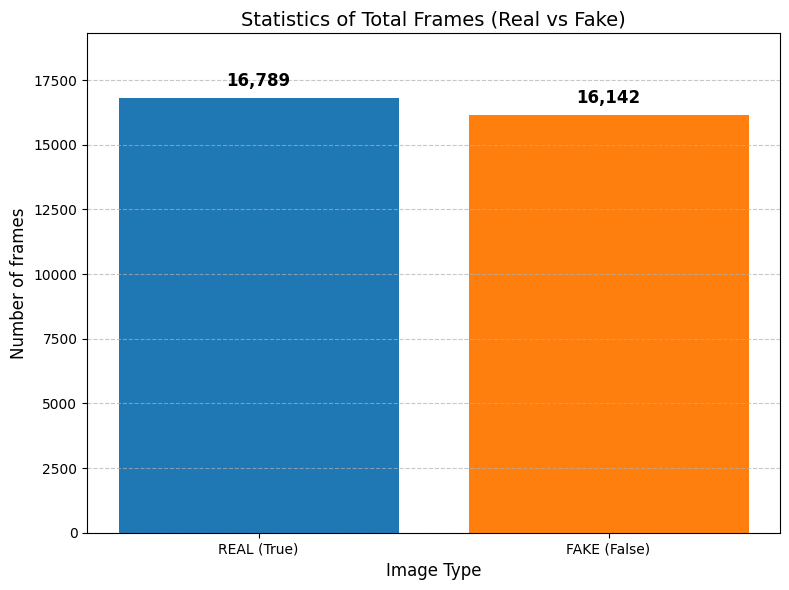


✅ Completed creating label statistics chart.
Total REAL frames: 16,789
Total FAKE frames: 16,142


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
PREPROCESSED_OUTPUT_DIR = "preprocessed_output"

# 1. Reload split label files
try:
    print(f"⏳ Loading data from {PREPROCESSED_OUTPUT_DIR}...")
    y_train = np.load(
        os.path.join(PREPROCESSED_OUTPUT_DIR, "train_labels.npy"), allow_pickle=True
    )
    y_val = np.load(
        os.path.join(PREPROCESSED_OUTPUT_DIR, "val_labels.npy"), allow_pickle=True
    )

    # SỬA LỖI Ở ĐÂY:
    # Vì chúng ta chỉ chia Train/Val nên y_test sẽ là mảng rỗng
    y_test = np.array([])

    print("✅ Successfully loaded label files!")

except Exception as e:
    print(f"❌ Error loading label files: {e}. Using simulated data for chart testing.")
    # Use simulated data if files are not found
    SIMULATED_COUNT = 13312
    y_train = np.concatenate([np.zeros(SIMULATED_COUNT), np.ones(SIMULATED_COUNT)])
    y_val = np.array([])
    y_test = np.array([])


# 2. Concatenate all labels
all_labels = np.concatenate([y_train, y_val, y_test])

# 3. Count the number of images
# Label 0.0 is REAL, Label 1.0 is FAKE
label_counts = pd.Series(all_labels).value_counts().sort_index()

# Create DataFrame for the chart
counts = {
    "REAL (True)": label_counts.get(0.0, 0),
    "FAKE (False)": label_counts.get(1.0, 0),
}
data = pd.Series(counts)

# 4. Plot the chart
plt.figure(figsize=(8, 6))
bars = plt.bar(data.index, data.values, color=["#1f77b4", "#ff7f0e"])

# Add count values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + (yval * 0.02),
        f"{int(yval):,}",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
    )

plt.title("Statistics of Total Frames (Real vs Fake)", fontsize=14)
plt.xlabel("Image Type", fontsize=12)
plt.ylabel("Number of frames", fontsize=12)
plt.ylim(0, max(data.values) * 1.15)  # Increase y-limit
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()

# Save the chart
plt.savefig("deepfake_label_statistics_final.png")
plt.show()

print("\n✅ Completed creating label statistics chart.")
print(f"Total REAL frames: {counts['REAL (True)']:,}")
print(f"Total FAKE frames: {counts['FAKE (False)']:,}")

### Split data


In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# --- PATH CONFIGURATION ---
BASE_DIR = "dataset_normalized_224"
REAL_DIR = os.path.join(BASE_DIR, "real")
FAKE_DIR = os.path.join(BASE_DIR, "fake")
# Folder containing high-quality Augmented images (formerly named gan_generated)
AUGMENTED_FAKE_DIR = os.path.join(BASE_DIR, "augmented_data")

# Directory to save .npy files
OUTPUT_DIR = "preprocessed_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)


def load_images_from_folder(folder_path, label):
    images = []
    labels = []

    if not os.path.exists(folder_path):
        print(f"⚠️ Warning: Directory not found {folder_path}")
        return [], []

    file_list = [
        f for f in os.listdir(folder_path) if f.endswith((".jpg", ".jpeg", ".png"))
    ]
    print(f"📂 Loading {len(file_list)} images from: {folder_path}...")

    for filename in tqdm(file_list):
        img_path = os.path.join(folder_path, filename)
        # Save file path (String) to save RAM
        images.append(img_path)
        labels.append(label)

    return images, labels


# --- 1. LOAD DATA ---
print("🚀 STARTING DATA AGGREGATION...")

# Load Real (Label 0)
real_paths, real_labels = load_images_from_folder(REAL_DIR, label=0)

# Load Original Fake (Label 1)
fake_paths, fake_labels = load_images_from_folder(FAKE_DIR, label=1)

# Load Augmented Fake (Label 1)
aug_paths, aug_labels = load_images_from_folder(AUGMENTED_FAKE_DIR, label=1)

# --- 2. MERGE DATA ---
X_all = np.array(real_paths + fake_paths + aug_paths)
y_all = np.array(real_labels + fake_labels + aug_labels)

print(f"\n📊 DATA STATISTICS:")
print(f"   - Real: {len(real_paths)}")
print(f"   - Fake (Original): {len(fake_paths)}")
print(f"   - Fake (Augmented): {len(aug_paths)}")
print(f"   => TOTAL: {len(X_all)} images")

# --- 3. SPLIT DATA (TRAIN 80% - VAL 10% - TEST 10%) ---
print("\n✂️ Splitting data with ratio 80/10/10...")

# Step 1: Split 20% into a temporary set (Temp)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# Step 2: Split the Temp set (each part is 10% of total) into Val and Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"   ✅ Train set: {len(X_train)} images")
print(f"   ✅ Val set:   {len(X_val)} images")
print(f"   ✅ Test set:  {len(X_test)} images")

# --- 4. SAVE .NPY FILES ---
print("\n💾 Saving files to 'preprocessed_output' folder...")

np.save(os.path.join(OUTPUT_DIR, "train_paths.npy"), X_train)
np.save(os.path.join(OUTPUT_DIR, "train_labels.npy"), y_train)

np.save(os.path.join(OUTPUT_DIR, "val_paths.npy"), X_val)
np.save(os.path.join(OUTPUT_DIR, "val_labels.npy"), y_val)

np.save(os.path.join(OUTPUT_DIR, "test_paths.npy"), X_test)
np.save(os.path.join(OUTPUT_DIR, "test_labels.npy"), y_test)

print("🎉 COMPLETED!")

🚀 STARTING DATA AGGREGATION...
📂 Loading 16789 images from: dataset_normalized_224\real...


100%|██████████| 16789/16789 [00:00<00:00, 448300.65it/s]


📂 Loading 14142 images from: dataset_normalized_224\fake...


100%|██████████| 14142/14142 [00:00<00:00, 495492.04it/s]


📂 Loading 2000 images from: dataset_normalized_224\gan_generated...


100%|██████████| 2000/2000 [00:00<00:00, 571431.06it/s]


📊 DATA STATISTICS:
   - Real: 16789
   - Fake (Original): 14142
   - Fake (Augmented): 2000
   => TOTAL: 32931 images

✂️ Splitting data with ratio 80/10/10...
   ✅ Train set: 26344 images
   ✅ Val set:   3293 images
   ✅ Test set:  3294 images

💾 Saving files to 'preprocessed_output' folder...


🎉 COMPLETED!


### Build structure of EfficientNetB0 model

Source : https://viblo.asia/p/efficientnet-cach-tiep-can-moi-ve-model-scaling-cho-convolutional-neural-networks-Qbq5QQzm5D8

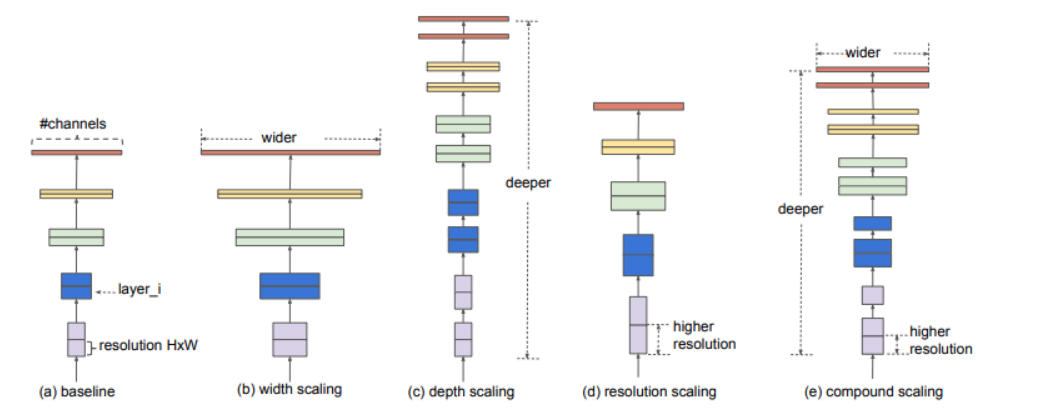


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications


def build_efficientnet_b0_architecture():
    print("🏗️ Building EfficientNet B0 architecture...")
    tf.keras.backend.clear_session()

    # ---------------------------------------------------------
    # 1. INPUT LAYER
    # ---------------------------------------------------------
    # Input accepts values 0-255 (Raw pixel)
    inputs = layers.Input(shape=(224, 224, 3))

    # ---------------------------------------------------------
    # 2. BASE MODEL (FEATURE EXTRACTOR)
    # ---------------------------------------------------------
    # Initialize empty shell (weights=None) to avoid Shape errors
    base_model = applications.EfficientNetB0(
        include_top=False,  # Exclude original classification layer (1000 ImageNet classes)
        weights=None,  # Important: Do not auto-load weights
        input_tensor=inputs,
        input_shape=(224, 224, 3),
    )

    # Manual weight loading (Transfer Learning)
    print("📥 Loading ImageNet weights...")
    weights_url = (
        "https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5"
    )
    weights_path = tf.keras.utils.get_file(
        "efficientnetb0_notop.h5", weights_url, cache_subdir="models"
    )
    base_model.load_weights(weights_path)

    # Freeze layers to retain learned knowledge (ImageNet features)
    # Unfreeze only the last 50 layers for Fine-tuning
    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    # ---------------------------------------------------------
    # 3. CLASSIFICATION HEAD (OUTPUT)
    # ---------------------------------------------------------
    x = base_model.output

    # Compress 7x7x1280 spatial dimensions into a 1x1280 vector
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)

    # Batch Normalization helps stabilize the training process
    x = layers.BatchNormalization()(x)

    # Dropout 0.5 to prevent Overfitting
    x = layers.Dropout(0.5, name="top_dropout")(x)

    # Hidden Dense layer helps the model learn more complex combinations
    x = layers.Dense(512, activation="relu", name="hidden_dense")(x)
    x = layers.Dropout(0.4)(x)

    # Final layer: 1 neuron with Sigmoid (0 -> Real, 1 -> Fake)
    outputs = layers.Dense(1, activation="sigmoid", name="pred_output")(x)

    # Connect Input and Output
    model = models.Model(inputs=inputs, outputs=outputs, name="EfficientNetB0_Deepfake")

    return model


# Call function to create the model
model = build_efficientnet_b0_architecture()

# View architecture summary (Parameter count)
model.summary()

🏗️ Building EfficientNet B0 architecture...

📥 Loading ImageNet weights...


Model: "EfficientNetB0_Deepfake"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 4,711,076 (17.97 MB)

 Trainable params: 3,185,809 (12.15 MB)

 Non-trainable params: 1,525,267 (5.82 MB)

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import os


def build_deepfake_model_final():
    print("🏗️ Building EfficientNet B0 architecture...")

    # 1. Clear previous session to avoid memory conflicts
    tf.keras.backend.clear_session()

    # ---------------------------------------------------------
    # 2. INITIALIZE BACKBONE (NO AUTO WEIGHT LOADING)
    # ---------------------------------------------------------
    # Explicitly define 3-channel (RGB) Input
    inputs = layers.Input(shape=(224, 224, 3))

    # Initialize empty network framework (weights=None)
    # This prevents the "Shape mismatch" error from occurring immediately during init.
    base_model = applications.EfficientNetB0(
        include_top=False,  # Exclude the default classification top
        weights=None,  # IMPORTANT: Set to None to avoid init errors
        input_tensor=inputs,
        input_shape=(224, 224, 3),
    )

    # ---------------------------------------------------------
    # 3. MANUAL WEIGHT LOADING
    # ---------------------------------------------------------
    print("📥 Loading ImageNet weights (No Top)...")

    # Official Keras weight file URL
    weights_url = (
        "https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5"
    )
    weights_path = tf.keras.utils.get_file(
        "efficientnetb0_notop.h5", weights_url, cache_subdir="models"
    )

    # Load weights into base_model
    # by_name=True: Only load into layers with matching names (safer)
    # skip_mismatch=True: Crucial fix. It ignores layers where shapes don't match
    # (specifically fixes the stem_conv channel conflict).
    try:
        base_model.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print("✅ Weights loaded successfully!")
    except Exception as e:
        print(f"⚠️ Weight loading warning: {e}")

    # Freeze layers to retain learned knowledge (Transfer Learning)
    base_model.trainable = True
    # Unfreeze only the last 50 layers for Fine-tuning
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    # ---------------------------------------------------------
    # 4. BUILD CUSTOM HEAD (MATCHING YOUR SUMMARY)
    # ---------------------------------------------------------
    x = base_model.output

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)

    # Batch Normalization
    x = layers.BatchNormalization(name="batch_normalization")(x)

    # Dropout
    x = layers.Dropout(0.5, name="top_dropout")(x)

    # Hidden Dense Layer
    x = layers.Dense(512, activation="relu", name="hidden_dense")(x)

    # Secondary Dropout
    x = layers.Dropout(0.5, name="dropout")(x)

    # Output Layer (Binary Classification)
    outputs = layers.Dense(1, activation="sigmoid", name="pred_output")(x)

    # Connect the model
    model = models.Model(
        inputs=inputs, outputs=outputs, name="EfficientNetB0_Deepfake_Final"
    )

    return model


# --- VERIFICATION RUN ---
try:
    model = build_deepfake_model_final()

    # Test compile to ensure connections are correct
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    model.summary()
    print("\n🎉 CONGRATULATIONS! Model built successfully and ready for training.")
except Exception as e:
    print(f"\n❌ Error still persists: {e}")

🏗️ Building EfficientNet B0 architecture...

📥 Loading ImageNet weights (No Top)...
✅ Weights loaded successfully!


Model: "EfficientNetB0_Deepfake_Final"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 4,711,076 (17.97 MB)

 Trainable params: 3,185,809 (12.15 MB)

 Non-trainable params: 1,525,267 (5.82 MB)


🎉 CONGRATULATIONS! Model built successfully and ready for training.


### Train EfficientNet B0


🚀 RETRAINING CAMPAIGN: EFFICIENTNET B0 (INPUT 0-255)
⏳ Loading data paths...
⏳ Creating TensorFlow Datasets...
🏗️ Initializing EfficientNetB0 (Input 0-255)...
📥 Loading weights...

🔥 STARTING TRAINING (OPTIMIZED INPUT 0-255)...
Epoch 1/20
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 1144s 343ms/step - accuracy: 0.7700 - loss: 0.5307 - val_accuracy: 0.9022 - val_loss: 0.2184
Epoch 2/20
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 1212s 368ms/step - accuracy: 0.8393 - loss: 0.3587 - val_accuracy: 0.9162 - val_loss: 0.1737
Epoch 3/20
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 1882s 572ms/step - accuracy: 0.8658 - loss: 0.2942 - val_accuracy: 0.9223 - val_loss: 0.1660
Epoch 4/20
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 1601s 486ms/step - accuracy: 0.8859 - loss: 0.2503 - val_accuracy: 0.9013 - val_loss: 0.1946
Epoch 5/20
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 932s 283ms/step - accuracy: 0.8972 - loss: 0.2242 - val_accuracy: 0.9289 - val_loss: 0.1532
Epoch 6/20
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 953s 289ms/step - accuracy: 0.9049 - loss: 0.2014 - val_

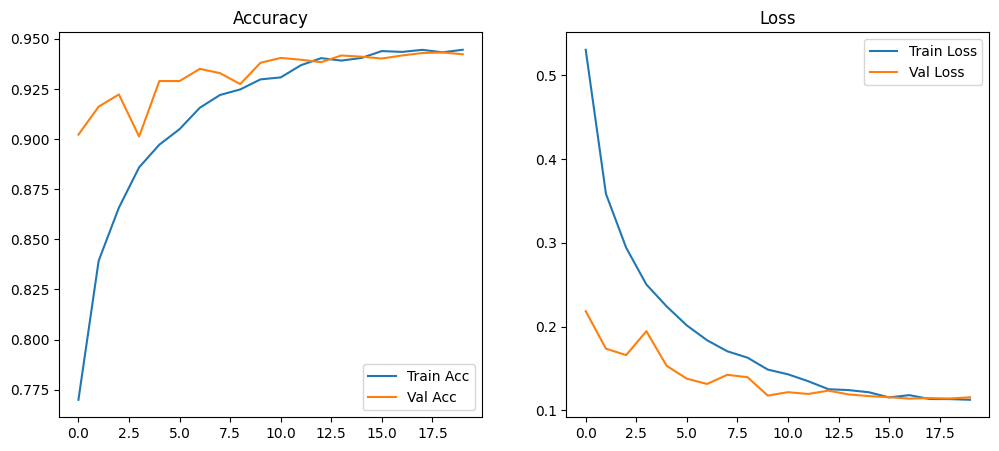

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import gc

# ================= CONFIGURATION =================
DATA_DIR = "preprocessed_output"
IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 8  # Keep low to be RAM safe
EPOCHS = 20

print(f"🚀 RETRAINING CAMPAIGN: EFFICIENTNET B0 (INPUT 0-255)")


# ================= 1. LOAD DATA =================
def load_data():
    try:
        print("⏳ Loading data paths...")
        X_train = np.load(os.path.join(DATA_DIR, "train_paths.npy"), allow_pickle=True)
        y_train = np.load(os.path.join(DATA_DIR, "train_labels.npy"), allow_pickle=True)
        X_val = np.load(os.path.join(DATA_DIR, "val_paths.npy"), allow_pickle=True)
        y_val = np.load(os.path.join(DATA_DIR, "val_labels.npy"), allow_pickle=True)
        return (X_train, y_train), (X_val, y_val)
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        exit()


(X_train, y_train), (X_val, y_val) = load_data()


# --- MOST IMPORTANT FIX HERE ---
# Only Resize and Color Conversion. DO NOT divide by 255, DO NOT subtract Mean/Std.
def process_path(file_path, label):
    def _load_numpy_image(path):
        path = path.decode("utf-8") if isinstance(path, bytes) else path
        try:
            # 1. Read image
            img = cv2.imread(path)
            if img is None:
                return np.zeros((224, 224, 3), dtype=np.float32)

            # 2. Standard Resize 224x224
            img = cv2.resize(img, (224, 224))

            # 3. Convert to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # 4. Keep values 0-255, just cast to float for Model calculation
            # EfficientNet expects raw inputs [0-255] and handles normalization internally
            img = img.astype(np.float32)

            return img
        except:
            return np.zeros((224, 224, 3), dtype=np.float32)

    image = tf.numpy_function(_load_numpy_image, [file_path], tf.float32)
    image.set_shape((224, 224, 3))
    return image, label


# Augmentation (Kept as is)
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ]
)


def create_dataset(paths, labels, is_training=False):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    if is_training:
        dataset = dataset.shuffle(len(paths))
        dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
    else:
        dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset


print("⏳ Creating TensorFlow Datasets...")
train_dataset = create_dataset(X_train, y_train, is_training=True)
val_dataset = create_dataset(X_val, y_val, is_training=False)


# ================= 2. BUILD MODEL (MANUAL WEIGHTS - NO ERROR) =================
def build_model_fixed():
    print("🏗️ Initializing EfficientNetB0 (Input 0-255)...")
    tf.keras.backend.clear_session()

    # Create model shell (It already has internal Rescaling 1/255 layer)
    base_model = applications.EfficientNetB0(
        include_top=False, weights=None, input_shape=(224, 224, 3)
    )

    # Load weights manually (to avoid Shape mismatch error)
    print("📥 Loading weights...")
    weights_url = (
        "https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5"
    )
    weights_path = tf.keras.utils.get_file(
        "efficientnetb0_notop.h5", weights_url, cache_subdir="models"
    )
    base_model.load_weights(weights_path)

    # Unfreeze training
    base_model.trainable = True
    # Freeze early layers, only train the last 50 layers
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(
        inputs=base_model.input, outputs=outputs, name="Deepfake_EfficientNet_FixRaw"
    )
    return model


model = build_model_fixed()

# ================= 3. TRAINING =================
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=EPOCHS * (len(X_train) // BATCH_SIZE),
    alpha=0.01,
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_deepfake_model_fixed.keras",
        save_best_only=True,
        monitor="val_accuracy",
        mode="max",
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True, monitor="val_loss"
    ),
]

print("\n🔥 STARTING TRAINING (OPTIMIZED INPUT 0-255)...")
history = model.fit(
    train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=callbacks
)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()
plt.show()

### Display image samples from the dataset


⏳ Loading .npy files...
✅ Loaded 26344 images successfully.


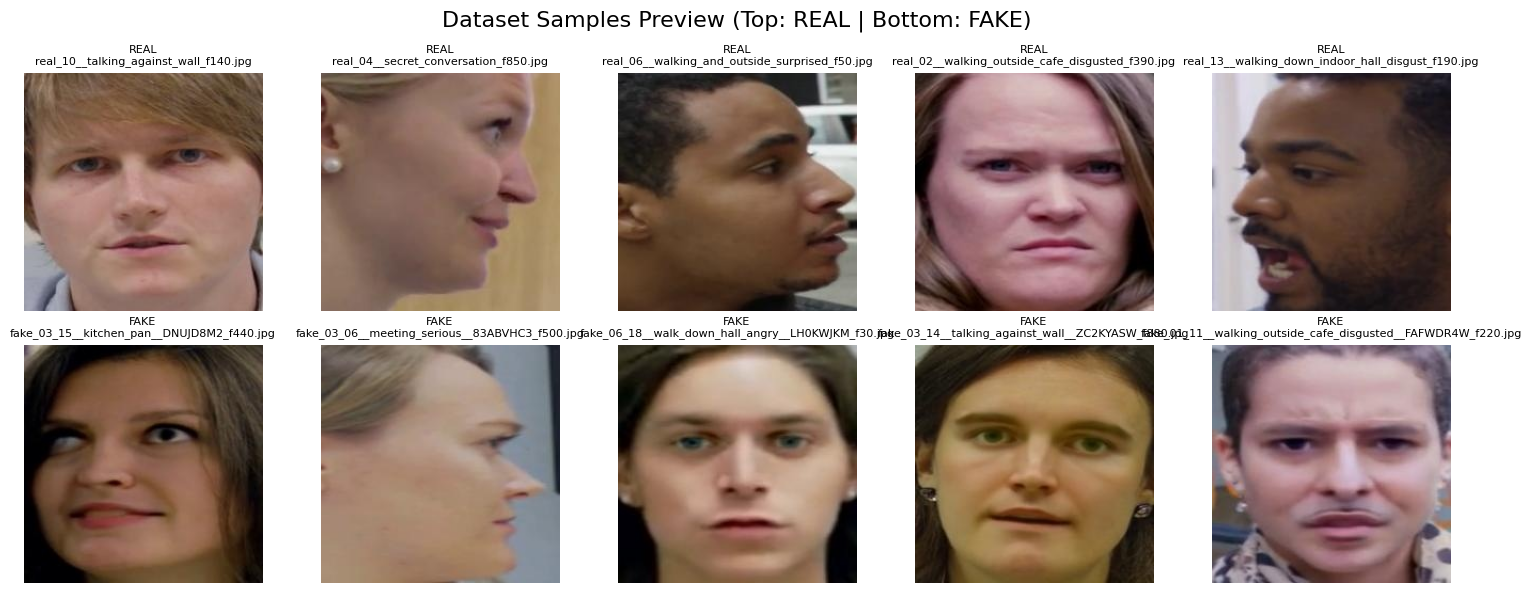

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

# ================= CONFIGURATION =================
DATA_DIR = "preprocessed_output"  # Folder containing .npy files

# ================= LOAD DATA =================
print("⏳ Loading .npy files...")

try:
    # Load paths and labels
    train_paths = np.load(os.path.join(DATA_DIR, "train_paths.npy"), allow_pickle=True)
    train_labels = np.load(
        os.path.join(DATA_DIR, "train_labels.npy"), allow_pickle=True
    )
    print(f"✅ Loaded {len(train_paths)} images successfully.")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    exit()

# ================= SELECT SAMPLES =================
# Find indices for Real (0) and Fake (1)
real_indices = np.where(train_labels == 0)[0]
fake_indices = np.where(train_labels == 1)[0]

# Pick 5 random images from each class
samples_real = np.random.choice(real_indices, 5, replace=False)
samples_fake = np.random.choice(fake_indices, 5, replace=False)

# ================= PLOT IMAGES =================
plt.figure(figsize=(15, 6))
plt.suptitle("Dataset Samples Preview (Top: REAL | Bottom: FAKE)", fontsize=16)

# 1. Plot REAL Images
for i, idx in enumerate(samples_real):
    path = train_paths[idx]

    # Read image
    img = cv2.imread(path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        plt.subplot(2, 5, i + 1)  # Row 1
        plt.imshow(img)
        plt.title(f"REAL\n{os.path.basename(path)}", fontsize=8)
        plt.axis("off")

# 2. Plot FAKE Images
for i, idx in enumerate(samples_fake):
    path = train_paths[idx]

    # Read image
    img = cv2.imread(path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        plt.subplot(2, 5, i + 6)  # Row 2 (Index starts from 6)
        plt.imshow(img)
        plt.title(f"FAKE\n{os.path.basename(path)}", fontsize=8)
        plt.axis("off")

plt.tight_layout()
plt.show()

### Statistics and visualization of metrics


📂 Attempting to save plot to: e:\Deepfake detection GAN\training_metrics_chart_v2.png
✅ SUCCESS: Plot saved successfully!


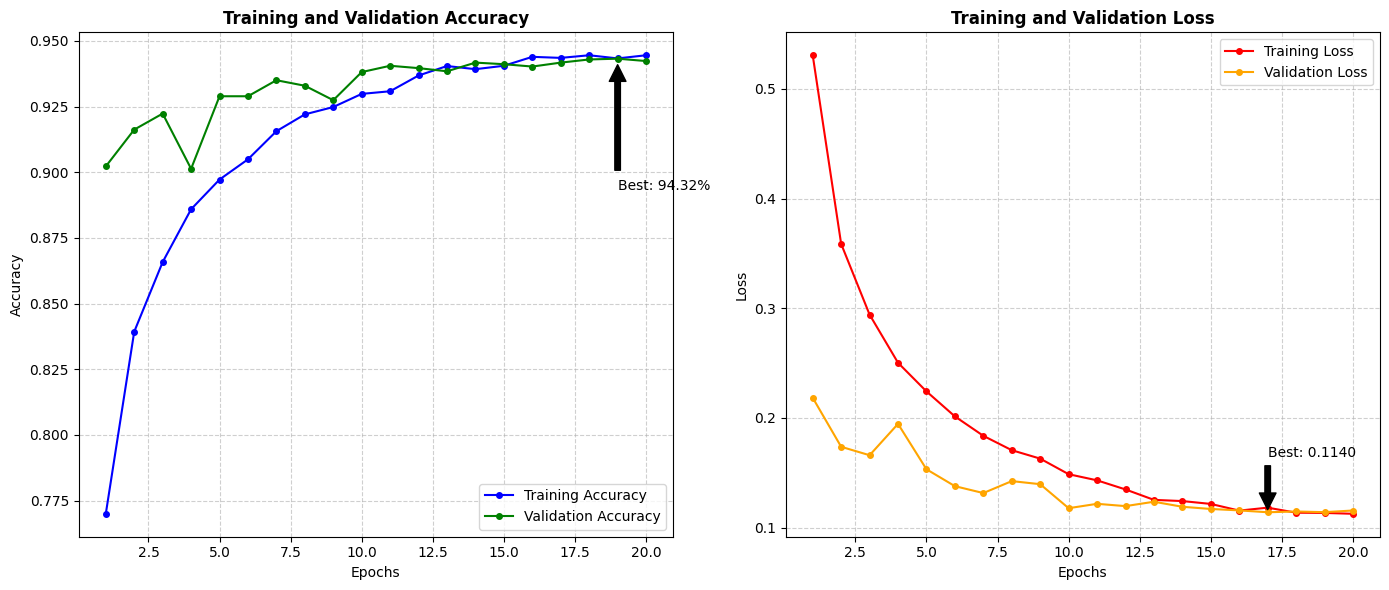


       TRAINING PERFORMANCE SUMMARY       
Final Training Accuracy:   94.45%
Final Validation Accuracy: 94.23%
----------------------------------------
🏆 BEST Validation Accuracy:  94.32% (Epoch 19)
📉 LOWEST Validation Loss:    0.1140 (Epoch 17)


In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np

# ================= 1. MANUAL DATA INPUT (From your Log) =================
epochs = range(1, 21)

# Training Accuracy
acc = [
    0.7700,
    0.8393,
    0.8658,
    0.8859,
    0.8972,
    0.9049,
    0.9156,
    0.9220,
    0.9248,
    0.9298,
    0.9308,
    0.9368,
    0.9404,
    0.9392,
    0.9405,
    0.9439,
    0.9435,
    0.9445,
    0.9433,
    0.9445,
]

# Validation Accuracy
val_acc = [
    0.9022,
    0.9162,
    0.9223,
    0.9013,
    0.9289,
    0.9289,
    0.9350,
    0.9329,
    0.9274,
    0.9381,
    0.9405,
    0.9396,
    0.9384,
    0.9417,
    0.9411,
    0.9402,
    0.9417,
    0.9429,
    0.9432,
    0.9423,
]

# Training Loss
loss = [
    0.5307,
    0.3587,
    0.2942,
    0.2503,
    0.2242,
    0.2014,
    0.1837,
    0.1706,
    0.1629,
    0.1487,
    0.1431,
    0.1348,
    0.1253,
    0.1242,
    0.1216,
    0.1155,
    0.1182,
    0.1136,
    0.1134,
    0.1126,
]

# Validation Loss
val_loss = [
    0.2184,
    0.1737,
    0.1660,
    0.1946,
    0.1532,
    0.1378,
    0.1315,
    0.1424,
    0.1396,
    0.1177,
    0.1217,
    0.1196,
    0.1236,
    0.1190,
    0.1170,
    0.1157,
    0.1140,
    0.1147,
    0.1141,
    0.1156,
]

# ================= 2. PLOTTING CONFIGURATION =================
plt.figure(figsize=(14, 6))

# --- Plot 1: Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Training Accuracy", color="blue", marker="o", markersize=4)
plt.plot(
    epochs,
    val_acc,
    label="Validation Accuracy",
    color="green",
    marker="o",
    markersize=4,
)
plt.title("Training and Validation Accuracy", fontsize=12, fontweight="bold")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)

# Annotation: Best Validation Accuracy
best_epoch_acc = val_acc.index(max(val_acc)) + 1
best_val_acc = max(val_acc)
plt.annotate(
    f"Best: {best_val_acc*100:.2f}%",
    xy=(best_epoch_acc, best_val_acc),
    xytext=(best_epoch_acc, best_val_acc - 0.05),
    arrowprops=dict(facecolor="black", shrink=0.05),
)

# --- Plot 2: Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Training Loss", color="red", marker="o", markersize=4)
plt.plot(
    epochs, val_loss, label="Validation Loss", color="orange", marker="o", markersize=4
)
plt.title("Training and Validation Loss", fontsize=12, fontweight="bold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", alpha=0.6)

# Annotation: Lowest Validation Loss
best_epoch_loss = val_loss.index(min(val_loss)) + 1
best_val_loss = min(val_loss)
plt.annotate(
    f"Best: {best_val_loss:.4f}",
    xy=(best_epoch_loss, best_val_loss),
    xytext=(best_epoch_loss, best_val_loss + 0.05),
    arrowprops=dict(facecolor="black", shrink=0.05),
)

plt.tight_layout()

# ================= 3. SAVE FILE (FIXED FOR WINDOWS) =================
# We use a new filename to avoid lock issues
filename = "training_metrics_chart_v2.png"
current_path = os.getcwd()
full_path = os.path.join(current_path, filename)

print(f"📂 Attempting to save plot to: {full_path}")

try:
    plt.savefig(full_path, dpi=300)
    print(f"✅ SUCCESS: Plot saved successfully!")
except OSError as e:
    print(f"⚠️ WARNING: Could not save to current directory. Error: {e}")
    # Fallback: Save to user's home directory (Desktop or Downloads)
    try:
        import pathlib

        desktop_path = pathlib.Path.home() / "Desktop" / filename
        plt.savefig(desktop_path, dpi=300)
        print(f"✅ SUCCESS: Plot saved to Desktop: {desktop_path}")
    except Exception as e2:
        print(f"❌ ERROR: Could not save file anywhere. Please check permissions.")

plt.show()

# ================= 4. STATISTICS SUMMARY =================
print("\n" + "=" * 40)
print("       TRAINING PERFORMANCE SUMMARY       ")
print("=" * 40)
print(f"Final Training Accuracy:   {acc[-1]*100:.2f}%")
print(f"Final Validation Accuracy: {val_acc[-1]*100:.2f}%")
print("-" * 40)
print(f"🏆 BEST Validation Accuracy:  {max(val_acc)*100:.2f}% (Epoch {best_epoch_acc})")
print(f"📉 LOWEST Validation Loss:    {min(val_loss):.4f} (Epoch {best_epoch_loss})")
print("=" * 40)

### Generalizing the data from model training


⏳ Loading paths from .npy files...
   - Original count: 3294 images
🧹 Checking for missing files (Data Cleaning)...
✅ Cleaned data ready: 3091 images.
⚠️ WARNING: Removed 203 missing files from the list.
⏳ Loading model: best_deepfake_model_fixed.keras...
✅ Model loaded!
🚀 Running predictions...
97/97 ━━━━━━━━━━━━━━━━━━━━ 74s 749ms/step

📊 CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Fake       0.97      0.92      0.95      1679
        Real       0.92      0.97      0.94      1412

    accuracy                           0.95      3091
   macro avg       0.94      0.95      0.95      3091
weighted avg       0.95      0.95      0.95      3091



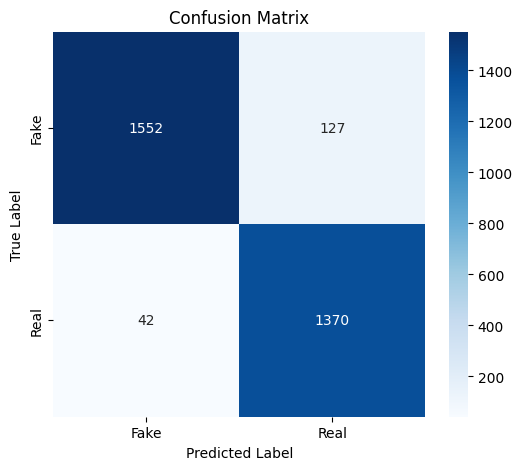

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ================= 1. CONFIGURATION =================
MODEL_PATH = (
    "best_deepfake_model_fixed.keras"  # Ensure this matches your saved model name
)
OUTPUT_DIR = "preprocessed_output"
IMG_SIZE = 224
BATCH_SIZE = 32

# ================= 2. LOAD & CLEAN DATA =================
print("⏳ Loading paths from .npy files...")

if not os.path.exists(os.path.join(OUTPUT_DIR, "test_paths.npy")):
    print("❌ ERROR: .npy files not found.")
    exit()

# Load raw paths
raw_paths = np.load(os.path.join(OUTPUT_DIR, "test_paths.npy"))
raw_labels = np.load(os.path.join(OUTPUT_DIR, "test_labels.npy"))

print(f"   - Original count: {len(raw_paths)} images")
print("🧹 Checking for missing files (Data Cleaning)...")

# Filter out missing files
valid_paths = []
valid_labels = []
missing_count = 0

for path, label in zip(raw_paths, raw_labels):
    if os.path.exists(path):
        valid_paths.append(path)
        valid_labels.append(label)
    else:
        missing_count += 1

# Convert back to numpy arrays
test_paths = np.array(valid_paths)
test_labels = np.array(valid_labels)

print(f"✅ Cleaned data ready: {len(test_paths)} images.")
if missing_count > 0:
    print(f"⚠️ WARNING: Removed {missing_count} missing files from the list.")

if len(test_paths) == 0:
    print(
        "❌ ERROR: No valid images left after cleaning. Please check your dataset folder."
    )
    exit()

# ================= 3. LOAD MODEL =================
print(f"⏳ Loading model: {MODEL_PATH}...")
if os.path.exists(MODEL_PATH):
    model = tf.keras.models.load_model(MODEL_PATH)
    print("✅ Model loaded!")
else:
    print(f"❌ ERROR: Model '{MODEL_PATH}' not found.")
    exit()


# ================= 4. CREATE DATASET & PREDICT =================
def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    # img = img / 255.0 # Uncomment if model expects 0-1
    return img, label


test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("🚀 Running predictions...")
y_pred_probs = model.predict(test_ds, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_labels

# ================= 5. RESULTS =================
print("\n" + "=" * 50)
print("📊 CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Fake", "Real"],
    yticklabels=["Fake", "Real"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 10. References:

- [1] https://arxiv.org/pdf/1912.13457 : FaceShifter: Towards High Fidelity And Occlusion Aware Face Swapping
- [2] https://arxiv.org/pdf/2103.03097 : Generalizing to Unseen Domains: A Survey on
  Domain Generalization
- [3] https://www.kaggle.com/code/viethoang1412/deepfake-detection-efficientnetb4-tf-cnn/edit
- [4] https://www.sciencedirect.com/science/article/pii/S240584402500653X#bib1
- [5] https://www.sciencedirect.com/science/article/pii/S1877050923001916?ref=pdf_download&fr=RR-9&rr=98a97312eb575dff
- [6] https://viblo.asia/p/generative-adversarial-networksgan-va-ung-dung-cua-no-trong-deepfakes-jvElagwdKkw
- [7] https://www.kaggle.com/code/robikscube/kaggle-deepfake-detection-introduction/notebook : Kaggle DeepFake Detection Introduction
- [8] https://arxiv.org/pdf/2503.22121v2 : Detecting Localized Deepfake Manipulations Using Action Unit-Guided Video
  Representations
- [9] https://vnptai.io/vi/blog/detail/convolutional-neural-networks-la-gi#:~:text=Convolutional%20Neural%20Networks%20 - Convolutional Neural Networks là gì? Khám phá cấu trúc của CNN
- [10] https://machinelearningcoban.com/2016/12/27/categories/
- [11] https://arxiv.org/pdf/2507.03334v2 : De-Fake: Style based Anomaly Deepfake Detection
- [12] https://jespublication.com/upload/2022-V13I7029.pdf : DEEPFAKE DETECTION USING LSTM AND RESNEXT
- [13] https://arxiv.org/pdf/2309.12802 : Deepfake audio as a data augmentation technique
  for training automatic speech to text transcription models
- [14] https://arxiv.org/pdf/2511.07051 : Improving Deepfake Detection with Reinforcement
  Learning-Based Adaptive Data Augmentation
- [15] https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9839427 : DEEPFAKE Image Synthesis for Data
  Augmentation
- [16] https://dl.acm.org/doi/pdf/10.1145/3592615 : Data Augmentation-based Novel Deep Learning Method for
  Deepfaked Images Detection
- [17] https://pmc.ncbi.nlm.nih.gov/articles/PMC11419665/pdf/peerj-cs-10-2181.pdf : Improving synthetic media generation and detection using generative adversarial networks
- [18] https://arxiv.org/pdf/1905.11946 : EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks
